# Részvényindexek EDA – Adathalmaz bemutatása

A 11. feladathoz tartozó adatot használom fel, a projektben a data mappába helyezvve.

Ebben a jegyzetfüzetben az `data/usa_stocks_data` könyvtárban található, nyilvánosan elérhető amerikai részvényindex-adatokat vizsgálom. A forrás tartalmazza a három nagy index (S&P 500, Dow Jones, Nasdaq-100) vállalati összetételét (`index/constituents`), az indexek historikus teljesítményét (`index/perf`), valamint több száz egyedi részvény napi árfolyam-sorozatát (`stock_prices`).

 - Forrás: a dataset az amerikai tőzsdéken jegyzett vállalatok nyilvános történeti adatait gyűjti össze CSV formában. A vállalati listák mezői (ticker, vállalatnév, szektor, iparág, alapítás éve stb.) közvetlenül felhasználhatók, míg az index- és árfolyam-fájlok időbélyeg + OHLCV struktúrát követnek.
 - Szerkezet: minden index/vállalati fájl első sora oszlopfejléceket tartalmaz, a rekordok soronkénti CSV formátumúak. A notebook során a `sp500.csv`-t használom elsődleges vállalati törzsadatként (mert naprakészebb és teljesebb metrikákat ad), míg az index teljesítményeket a `index/perf` almappából töltöm be `Date` indexeléssel.

A későbbi cellákban részletesen betöltöm, megtisztítom, majd EDA célokra elemezhető formátumba alakítom ezeket az adatokat.

# Problémakör és célkitűzés bemutatása

Ez a kutatás az S&P 500, Nasdaq 100 és Dow Jones indexek statisztikai elemzésére fókuszál, feltárva a részvénypiaci struktúrák belső kapcsolatait. A cél annak igazolása, hogy a tisztán korreláció-alapú hierarchikus klaszterezés képes-e hűen rekonstruálni a hivatalos GICS szektorfelosztást. Az elemzés elméleti motivációja a piaci hatékonyság határainak keresése, gyakorlati célja pedig a valódi diverzifikáció elősegítése, feltárva a szektorokon átívelő rejtett kockázati közösségeket. A vizsgálat ezen túl kiterjed az időbeli anomáliákra is, mint az éjszakai hozameltolódások és a havi szezonalitás vizsgálata.

# Kezdeti hipotézisek

Ezekre a vizsgálandó hipotéziseket két módon gyüjtöttem:
 - Korábbi ismeretekre alapozva, elképzeléseim alátámasztására, bizonyos esetben megcáfolására
    - Indexek hozama nem autokorrelál
    - Indexek volatilitása autokorrelál
    - After hours-normal hours hozam vizsgálata
 - Elemzés közben szembetűnt valami, és kiváncsi voltam rá
    - Az inflációs környezet hatása szektoronként
    - Korreláció szerinti csoportosítás


In [256]:

import re
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import calendar

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.optimize import linear_sum_assignment


from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    accuracy_score,
    f1_score, recall_score
)

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# ábrázolási beállítások
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

random_state = 42

print("Könyvtárak importálva!")

Könyvtárak importálva!


Könyvtárak elérési útjai

In [257]:
data_path = Path('data/usa_stocks_data')
constituents_path = data_path / 'index/constituents'
idxperf_path = data_path / 'index/perf'
stock_prices_path = data_path / 'stock_prices'


# Adatbetöltés és Adattisztítás
## S&P 500
### Forrásfájl kiválasztása
Amint látható, S&P 500 indexhez 2 fájl is található. Ezeket megvizsgálom, és a jelenlegi állapotához közelebbit használom a továbbiakban

In [258]:
sp500_companies1 = pd.read_csv(constituents_path / 'sp500.csv', header=0, index_col=0)
sp500_companies2 = pd.read_csv(constituents_path / 'sp500_companies.csv', header=0, index_col=0)

# Szimbólumok összehasonlítása
print(f"sp500_companies.csv rekordjainak száma: {len(sp500_companies1)}")
print(f"sp500.csv rekordjainak száma: {len(sp500_companies2)}")

sp500_symbols = set(sp500_companies1['Symbol'].unique())
sp500_companies_symbols = set(sp500_companies2['Symbol'].unique())

print(f"\nSP500.csv egyedi szimbólumok száma: {len(sp500_symbols)}")
print(f"SP500_companies.csv egyedi szimbólumok száma: {len(sp500_companies_symbols)}")

# Szimbólumok, amelyek csak az egyikben vannak
only_sp500 = sp500_symbols - sp500_companies_symbols
only_sp500_companies = sp500_companies_symbols - sp500_symbols
common_symbols = sp500_symbols & sp500_companies_symbols

print(f"\nKözös szimbólumok: {len(common_symbols)}")
print(f"Csak SP500-ban lévő szimbólumokszáma: {len(only_sp500)}")
print(f"Csak SP500_companies-ben lévő szimbólumok száma: {len(only_sp500_companies)}")

print(f"\nCsak SP500-ban lévő szimbólumok: {list(only_sp500)}")
print(f"Csak SP500_companies-ben lévő szimbólumok: {list(only_sp500_companies)}")



sp500_companies.csv rekordjainak száma: 503
sp500.csv rekordjainak száma: 501

SP500.csv egyedi szimbólumok száma: 503
SP500_companies.csv egyedi szimbólumok száma: 501

Közös szimbólumok: 500
Csak SP500-ban lévő szimbólumokszáma: 3
Csak SP500_companies-ben lévő szimbólumok száma: 1

Csak SP500-ban lévő szimbólumok: ['ABNB', 'VLTO', 'BX']
Csak SP500_companies-ben lévő szimbólumok: ['NWL']


Azt, hogy nem 500 rekordot tartalmaznak a fájlok az magyarázza, hogy bizonyos cégeknek több osztályú részvénye is része a rekordoknak, pl.: GOOG (Class B), GOOGL (Class A)

In [259]:
#Attribútumok vizsgálata
print(f"\nsp500.csv oszlopok:\n {list(sp500_companies1.columns)}\n")
print(f"\nsp500_companies.csv oszlopok:\n {list(sp500_companies2.columns)}\n")


sp500.csv oszlopok:
 ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded', 'Shares Outstanding']


sp500_companies.csv oszlopok:
 ['Symbol', 'Company Name', 'Industry', 'Sector', 'Founded', 'shares outstanding']



A rekordok számának viszgálatából kiderült, hogy egyik fájlban sincs duplikált adat.

Az sp500_companies.csv-ben található egyedül az NWL (Newell Brands Inc.), ami 2023 szeptember 18.-án kikerült az indexből.
Az sp500.csv-ben található egyedül 'ABNB', 'VLTO', 'BX', (Airbnb, Inc., Blackstone Inc., Veralto Corp.), amik 2023 szeptember 18.-án, és 2023 október 2.-án kerültek fel az indexre.
Ezek alapján az sp500.csv aktuálisabb információt tartalmaz.

Emellet az sp500.csv több információt tartalmaz a cégekről, és összes sp500_companies.csv-ben találhtó attribútum is jelen van.

Tehát innentől az sp500.csv-t használom az S&P 500 teljesítményének vizsgálatára.


In [260]:
sp500_companies = pd.read_csv(constituents_path / 'sp500.csv', header=0, index_col=0)

### Adatok tisztítása

Ebben a fejezetben az
 - Oszlopok nevét formázom
 - Oszlopok típusát állítom be helyesre
 - Átnevezek bizonyos oszlopokat, hogy a többi index oszlopával konzisztens legyem
 - *Founded* adatokból kinyerem a pontos évet minden rekord esetén

In [261]:
text_cols = ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location']
for col in text_cols:
    sp500_companies[col] = sp500_companies[col].astype('string').str.strip()

#Indexek közötti konzisztencia érdekében
sp500_companies.rename(columns={'GICS Sector': 'Sector'}, inplace=True)
sp500_companies.rename(columns={'GICS Sub-Industry': 'Industry'}, inplace=True)

# Oszlopok típuskonverziója
sp500_companies['Date added'] = pd.to_datetime(sp500_companies['Date added'], errors='coerce')
sp500_companies['CIK'] = sp500_companies['CIK'].astype(int)
sp500_companies['Shares Outstanding'] = sp500_companies['Shares Outstanding'].astype(int)

# Évszám szabványszerű meghatározása, mert volt ahol eltért az adatban
def extract_year(x):
    if pd.isna(x):
        return pd.NA
    years = [int(y) for y in re.findall(r'(\d{4})', str(x))]
    return min(years) if years else pd.NA

sp500_companies['Founded'] = sp500_companies['Founded'].apply(extract_year)
sp500_companies['Founded'] = pd.to_numeric(sp500_companies['Founded'], errors='coerce')

### Attribútumok vizsgálata
Ebben a fejezetben:
 - Megvizsgálom, hogy hol hiányzok adat, és feltöltöm őket
 - Megvizsgálom a kategorikus változókat, és azt, hogy megfelel-e az iparban használtakkal

In [262]:
sp500_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Symbol                 503 non-null    string        
 1   Security               503 non-null    string        
 2   Sector                 503 non-null    string        
 3   Industry               502 non-null    string        
 4   Headquarters Location  503 non-null    string        
 5   Date added             491 non-null    datetime64[ns]
 6   CIK                    503 non-null    int64         
 7   Founded                503 non-null    int64         
 8   Shares Outstanding     503 non-null    int64         
dtypes: datetime64[ns](1), int64(3), string(5)
memory usage: 39.3 KB


Itt látható, hogy a Date added, és industry attribútumok hiányoznak bizonyos helyekről, és hogy az oszloptípusok már helyesen vannak beállítva.

#### Hiányzó adatok vizsgálata:

 - Industry:

In [263]:
sp500_companies[sp500_companies["Industry"].isna()]

,Symbol,Security,Sector,Industry,Headquarters Location,Date added,CIK,Founded,Shares Outstanding
468,VLTO,Veralto,Industrials,<NA>,"Waltham, Massachusetts",2023-10-02,1967680,2023,246291005


Hiányzó adat: Environmental & Facilities Services, ennek hozzáadása

In [264]:
sp500_companies.loc[sp500_companies["Symbol"] == "VLTO", "Industry"] = "Environmental & Facilities Services"

 - Date added

In [265]:
sp500_companies[sp500_companies["Date added"].isna()]

,Symbol,Security,Sector,Industry,Headquarters Location,Date added,CIK,Founded,Shares Outstanding
156,D,Dominion Energy,Utilities,Electric Utilities,"Richmond, Virginia",NaT,715957,1983,836772984
186,ES,Eversource,Utilities,Multi-Utilities,"Hartford, Connecticut",NaT,72741,1966,349085992
211,FCX,Freeport-McMoRan,Materials,Copper,"Phoenix, Arizona",NaT,831259,1912,1433639982
243,HUM,Humana,Health Care,Managed Health Care,"Louisville, Kentucky",NaT,49071,1961,123906995
404,ROK,Rockwell Automation,Industrials,Electrical Components & Equipment,"Milwaukee, Wisconsin",NaT,1024478,1903,114860005
415,SRE,Sempra Energy,Utilities,Multi-Utilities,"San Diego, California",NaT,1032208,1998,629307049
435,TROW,T. Rowe Price,Financials,Asset Management & Custody Banks,"Baltimore, Maryland",NaT,1113169,1937,224295018
445,TXN,Texas Instruments,Information Technology,Semiconductors,"Dallas, Texas",NaT,97476,1930,907966030
457,USB,U.S. Bank,Financials,Diversified Banks,"Minneapolis, Minnesota",NaT,36104,1968,1556970036
482,WM,Waste Management,Industrials,Environmental & Facilities Services,"Houston, Texas",NaT,823768,1968,405059015


Hiányzó adatok hozzáadása:

In [266]:
missing_map = {
    "D":   "2016-11-30",
    "ES":  "2009-07-24",
    "FCX": "2011-07-01",
    "HUM": "2012-12-10",
    "ROK": "2000-03-12",
    "SRE": "2017-03-17",
    "TROW":"2019-07-29",
    "TXN": "2001-03-12",
    "USB": "1999-11-01",
    "WM":  "1998-08-31",
    "WY":  "1979-10-01",
    "WHR": "1959-04-01",
}

for sym, date in missing_map.items():
    sp500_companies.loc[(sp500_companies["Symbol"] == sym) & (sp500_companies["Date added"].isna()), "Date added"] = date

#### Kategórikus változók
 - Szektorok

In [267]:
print(f"Szektorok száma: {len(sp500_companies['Sector'].unique())}")
print(f"Szektorok lebontása: {sp500_companies['Sector'].value_counts()}")

Szektorok száma: 11
Szektorok lebontása: Sector
Industrials               76
Financials                72
Health Care               65
Information Technology    64
Consumer Discretionary    52
Consumer Staples          38
Real Estate               31
Utilities                 30
Materials                 29
Communication Services    23
Energy                    23
Name: count, dtype: Int64


11 Szektorból található cég van az indexben, ami megfelel a GICS által meghatározott szektorok számának.

 - Iparágak

In [268]:
print(f"Iparágak száma: {len(sp500_companies['Industry'].unique())}")
print(f"Iparágak lebontása: {sp500_companies['Industry'].value_counts()}")

Iparágak száma: 126
Iparágak lebontása: Industry
Health Care Equipment                           19
Semiconductors                                  15
Industrial Machinery & Supplies & Components    14
Application Software                            13
Electric Utilities                              13
                                                ..
Metal, Glass & Plastic Containers                1
Multi-Sector Holdings                            1
Computer & Electronics Retail                    1
Data Processing & Outsourced Services            1
Household Appliances                             1
Name: count, Length: 126, dtype: Int64


### S&P 500 teljesítményének betöltése

Ebben a fejezetben:
 - Betöltöm az adatot
 - Átkonvertálom a szükséges oszloptípusokat
 - Ellenőrzöm a megjelenítést

In [269]:
#Date indexként használva
sp500_perf = pd.read_csv(idxperf_path / 'SP500_perf.csv', parse_dates=['Date'], header=0, index_col=0)


 - Típus konverziók

In [270]:
sp500_perf.index = pd.to_datetime(sp500_perf.index,utc=True, errors='coerce')
sp500_perf.index = sp500_perf.index.tz_convert("America/New_York")
sp500_perf.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24060 entries, 1927-12-30 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24060 non-null  float64
 1   High          24060 non-null  float64
 2   Low           24060 non-null  float64
 3   Close         24060 non-null  float64
 4   Volume        24060 non-null  int64  
 5   Dividends     24060 non-null  float64
 6   Stock Splits  24060 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.5 MB


Az index és az össze attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

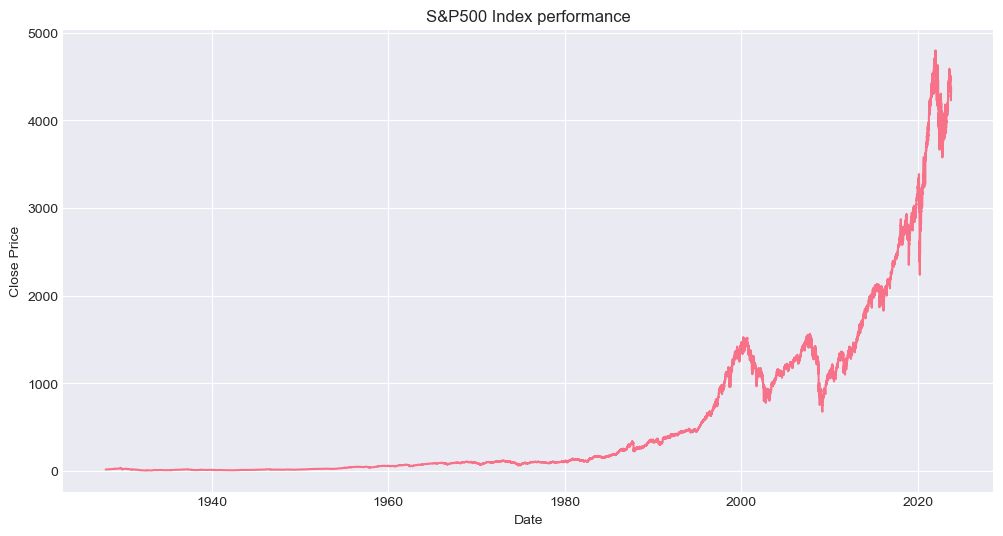

In [271]:
plt.plot(sp500_perf.index, sp500_perf["Close"])
plt.title("S&P500 Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

## Nasdaq 100
### Adatok tisztítása

Ebben a fejezetben
 - Betöltöm az adatokat
 - Oszlopok nevét formázom
 - Oszlopok típusát állítom be helyesre


In [272]:
nasdaq100_companies = pd.read_csv(constituents_path / 'nasdaq100_companies.csv', header=0, index_col=0)

text_cols = ['Symbol', 'Company Name', 'Industry', 'Sector']
for col in text_cols:
    nasdaq100_companies[col] = nasdaq100_companies[col].astype('string').str.strip()

nasdaq100_companies['Founded'] = pd.to_numeric(nasdaq100_companies['Founded'], errors='coerce')

### Attribútumok vizsgálata

In [273]:
nasdaq100_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              101 non-null    string 
 1   Company Name        101 non-null    string 
 2   Industry            101 non-null    string 
 3   Sector              101 non-null    string 
 4   Founded             89 non-null     float64
 5   shares outstanding  101 non-null    float64
dtypes: float64(2), string(4)
memory usage: 5.5 KB


Itt látható, hogy a Founded, attribútumok hiányoznak bizonyos helyekről, és hogy az oszloptípusok már helyesen vannak beállítva.

#### Hiányzó adatok vizsgálata
 - Founded

In [274]:
nasdaq100_companies[nasdaq100_companies["Founded"].isna()]

,Symbol,Company Name,Industry,Sector,Founded,shares outstanding
8,AVGO,Broadcom,Semiconductors,Technology,NaN,4.127360e+08
24,HON,Honeywell International,Conglomerates,Industrials,NaN,6.639610e+08
35,MDLZ,Mondelez International,Confectioners,Consumer Staples,NaN,1.360420e+09
45,CSX,CSX Corporation,Railroads,Industrials,NaN,2.006330e+09
52,MNST,Monster Beverage,Beverages - Non-Alcoholic,Consumer Staples,NaN,1.047520e+09
54,JD,JD.com,Internet Retail,Consumer Discretionary,NaN,1.573000e+09
66,ON,ON Semiconductor,Semiconductors,Technology,NaN,4.315290e+08
68,SGEN,Seagen,Biotechnology,Healthcare,NaN,1.876980e+08
69,EXC,Exelon,Utilities - Regulated Electric,Utilities,NaN,9.952191e+08
75,IDXX,IDEXX Laboratories,Diagnostics & Research,Healthcare,NaN,8.301240e+07


Hiányzó adatok hozzáadása:

In [275]:
missing_map = {
    "AVGO": 1961,
    "HON":  1885,
    "MDLZ": 1903,
    "CSX":  1980,
    "MNST": 1935,
    "JD":   1998,
    "ON":   1999,
    "SGEN": 1998,
    "EXC":  2000,
    "IDXX": 1983,
    "BKR":  1908,
    "SIRI": 2008
}

for sym, date in missing_map.items():
    nasdaq100_companies.loc[(nasdaq100_companies["Symbol"] == sym) & (nasdaq100_companies["Founded"].isna()), "Founded"] = date

nasdaq100_companies['Founded'] = nasdaq100_companies['Founded'].astype(int)

#### Kategórikus változók
Ebben a fejezetben
 - Átnevezek bizonyos attribútumokat, hogy konzisztens legyen a többi index-szel
 - Összehasonlítom, a már feldolgozott, S&P 500-zal


- Szektorok:

In [276]:
#Konzisztencia érdekében
nasdaq100_companies["Sector"] = nasdaq100_companies["Sector"].replace("Healthcare", "Health Care")
nasdaq100_companies["Sector"] = nasdaq100_companies["Sector"].replace("Technology", "Information Technology")

print(f"Szektorok száma: {len(nasdaq100_companies['Sector'].unique())}")
print(f"Szektorok lebontása: {nasdaq100_companies['Sector'].value_counts()}")

Szektorok száma: 10
Szektorok lebontása: Sector
Information Technology    37
Consumer Discretionary    15
Health Care               15
Communication Services    10
Industrials                9
Consumer Staples           7
Utilities                  4
Energy                     2
Financials                 1
Real Estate                1
Name: count, dtype: Int64


Itt már nem jelenik meg mind a 11 szektor, de ez azért van, mert míg az S&P 500 500 céget, a Nasdaq csak 100-at tartalmaz és tech-irányult, ezért a *Materials* szektorból nem tartalmaz céget.

Megfelelés ellenőrzése:

In [277]:
print(f"Nasdaq 100 szektorai megfelelnek az S&P 500 szektorainak? "
      f"{set(nasdaq100_companies['Sector'].unique()).issubset(set(sp500_companies['Sector'].unique()))} ")


Nasdaq 100 szektorai megfelelnek az S&P 500 szektorainak? True 


 - Iparágak:

In [278]:
print(f"Iparágak száma: {len(nasdaq100_companies['Industry'].unique())}")
print(f"Iparágak lebontása: {nasdaq100_companies['Industry'].value_counts()}")

Iparágak száma: 45
Iparágak lebontása: Industry
Semiconductors                         13
Software - Application                  9
Software - Infrastructure               7
Internet Retail                         5
Semiconductor Equipment & Materials     4
Drug Manufacturers - General            4
Biotechnology                           4
Utilities - Regulated Electric          3
Internet Content & Information          3
Beverages - Non-Alcoholic               3
Telecom Services                        3
Entertainment                           3
Medical Devices                         2
Diagnostics & Research                  2
Apparel Retail                          2
Staffing & Employment Services          2
Travel Services                         2
Discount Stores                         2
Auto Manufacturers                      2
Packaged Foods                          1
Health Information Services             1
Oil & Gas E&P                           1
Industrial Distribution     

Hasonló okokból itt sincs jelen az összes, S&P 500-nál megfigyelt iparág

### Nasdaq 100 teljesítményeének betöltése

Ebben a fejezetben:
 - Betöltöm az adatot
 - Átkonvertálom a szükséges oszloptípusokat
 - Ellenőrzöm a megjelenítést

In [279]:
# Date indexként használva
nasdaq100_perf = pd.read_csv(idxperf_path / 'Nasdaq100_perf.csv', parse_dates=['Date'], header=0, index_col=0)

 - Típus konverziók

In [280]:
nasdaq100_perf.index = pd.to_datetime(nasdaq100_perf.index,utc=True, errors='coerce')
nasdaq100_perf.index = nasdaq100_perf.index.tz_convert("America/New_York")
nasdaq100_perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9585 entries, 1985-10-01 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9585 non-null   float64
 1   High          9585 non-null   float64
 2   Low           9585 non-null   float64
 3   Close         9585 non-null   float64
 4   Volume        9585 non-null   int64  
 5   Dividends     9585 non-null   float64
 6   Stock Splits  9585 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 599.1 KB


Az index és az összes attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

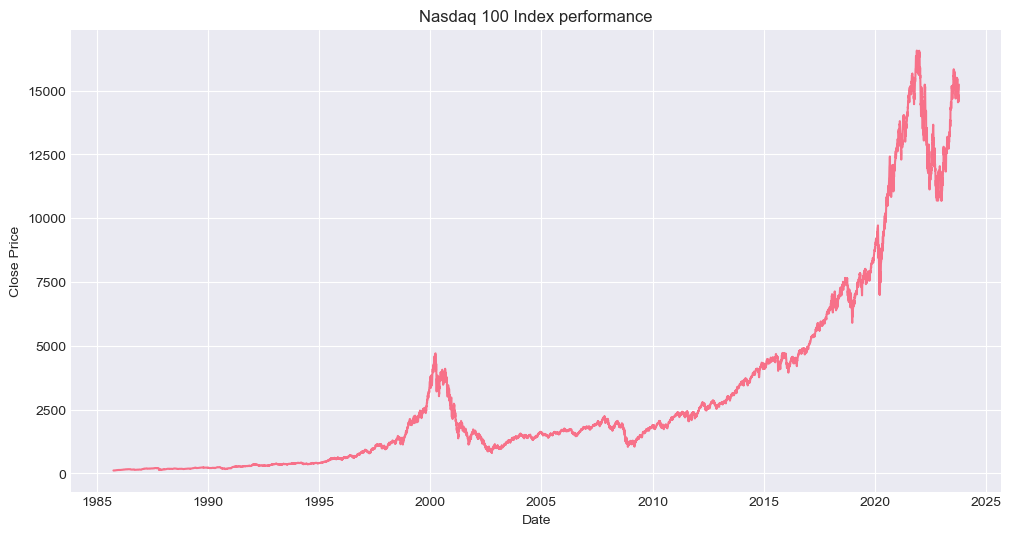

In [281]:
plt.plot(nasdaq100_perf.index, nasdaq100_perf["Close"])
plt.title("Nasdaq 100 Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

## Dow Jones
### Adatok tisztítása

Ebben a fejezetben
 - Betöltöm az adatokat
 - Oszlopok nevét formázom
 - Oszlopok típusát állítom be helyesre

In [282]:
dowjones_companies = pd.read_csv(constituents_path / 'dowjones_companies.csv', header=0, index_col=0)

text_cols = ['Symbol', 'Company Name', 'Industry', 'Sector']
for col in text_cols:
    dowjones_companies[col] = dowjones_companies[col].astype('string').str.strip()

dowjones_companies['Founded'] = pd.to_numeric(dowjones_companies['Founded'], errors='coerce')

### Attribútumok vizsgálata

In [283]:
dowjones_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Symbol        30 non-null     string 
 1   Company Name  30 non-null     string 
 2   Industry      30 non-null     string 
 3   Sector        30 non-null     string 
 4   Founded       28 non-null     float64
dtypes: float64(1), string(4)
memory usage: 1.4 KB


Itt látható, hogy a Founded, attribútumok hiányoznak bizonyos helyekről, és hogy az oszloptípusok már helyesen vannak beállítva.

#### Hiányzó adatok vizsgálata
 - Founded

In [284]:
dowjones_companies[dowjones_companies["Founded"].isna()]

,Symbol,Company Name,Industry,Sector,Founded
22,HON,Honeywell International,Conglomerates,Industrials,NaN
28,DOW,Dow Inc.,Chemicals,Materials,NaN


Hiányzó adatok hozzáadása:

In [285]:
missing_map = {
    "HON": 1906,
    "DOW":  1897
}

for sym, date in missing_map.items():
    dowjones_companies.loc[(dowjones_companies["Symbol"] == sym) & (dowjones_companies["Founded"].isna()), "Founded"] = date

dowjones_companies['Founded'] = dowjones_companies['Founded'].astype(int)

#### Kategórikus változók
Ebben a fejezetben
 - Átnevezek bizonyos attribútumokat, hogy konzisztens legyen a többi index-szel
 - Összehasonlítom, a már feldolgozott, S&P 500-zal


 - Szektorok

In [286]:
#Konzisztencia érdekében
dowjones_companies["Sector"] = dowjones_companies["Sector"].replace("Healthcare", "Health Care")
dowjones_companies["Sector"] = dowjones_companies["Sector"].replace("Technology", "Information Technology")

print(f"Szektorok száma: {len(dowjones_companies['Sector'].unique())}")
print(f"Szektorok lebontása: {dowjones_companies['Sector'].value_counts()}")

Szektorok száma: 9
Szektorok lebontása: Sector
Information Technology    6
Financials                5
Health Care               5
Industrials               4
Consumer Staples          3
Consumer Discretionary    3
Communication Services    2
Energy                    1
Materials                 1
Name: count, dtype: Int64


Itt már nem jelenik meg mind a 11 szektor, de ez azért van, mert ez az index már csak 30 cégből áll.

Megfelelés ellenőrzése:

In [287]:
print(f"Dow Jones Industry-k megfelelnek az S&P 500 szektorainak? "
      f"{set(dowjones_companies['Sector'].unique()).issubset(set(sp500_companies['Sector'].unique()))} ")

Dow Jones Industry-k megfelelnek az S&P 500 szektorainak? True 


 - Iparágak

In [288]:
print(f"Iparágak száma: {len(dowjones_companies['Industry'].unique())}")
print(f"Iparágak lebontása: {dowjones_companies['Industry'].value_counts()}")

Iparágak száma: 26
Iparágak lebontása: Industry
Drug Manufacturers - General           3
Credit Services                        2
Conglomerates                          2
Consumer Electronics                   1
Entertainment                          1
Chemicals                              1
Insurance - Property & Casualty        1
Capital Markets                        1
Aerospace & Defense                    1
Information Technology Services        1
Telecom Services                       1
Farm & Heavy Construction Machinery    1
Footwear & Accessories                 1
Semiconductors                         1
Restaurants                            1
Software - Infrastructure              1
Software - Application                 1
Communication Equipment                1
Beverages - Non-Alcoholic              1
Home Improvement Retail                1
Oil & Gas Integrated                   1
Household & Personal Products          1
Banks - Diversified                    1
Discount 

### Dow Jones teljesítményének betöltése
Ebben a fejezetben:
 - Betöltöm az adatot
 - Átkonvertálom a szükséges oszloptípusokat
 - Ellenőrzöm a megjelenítést

In [289]:
#Date indexként használva
dowjones_perf = pd.read_csv(idxperf_path / 'Dow_Jones_perf.csv', parse_dates=['Date'], header=0, index_col=0)

 - Típus konverziók

In [290]:
dowjones_perf.index = pd.to_datetime(dowjones_perf.index, utc=True, errors="coerce")
dowjones_perf.index = dowjones_perf.index.tz_convert("America/New_York")
dowjones_perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8004 entries, 1992-01-02 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          8004 non-null   float64
 1   High          8004 non-null   float64
 2   Low           8004 non-null   float64
 3   Close         8004 non-null   float64
 4   Volume        8004 non-null   int64  
 5   Dividends     8004 non-null   float64
 6   Stock Splits  8004 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 500.2 KB


Az index és az összes attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

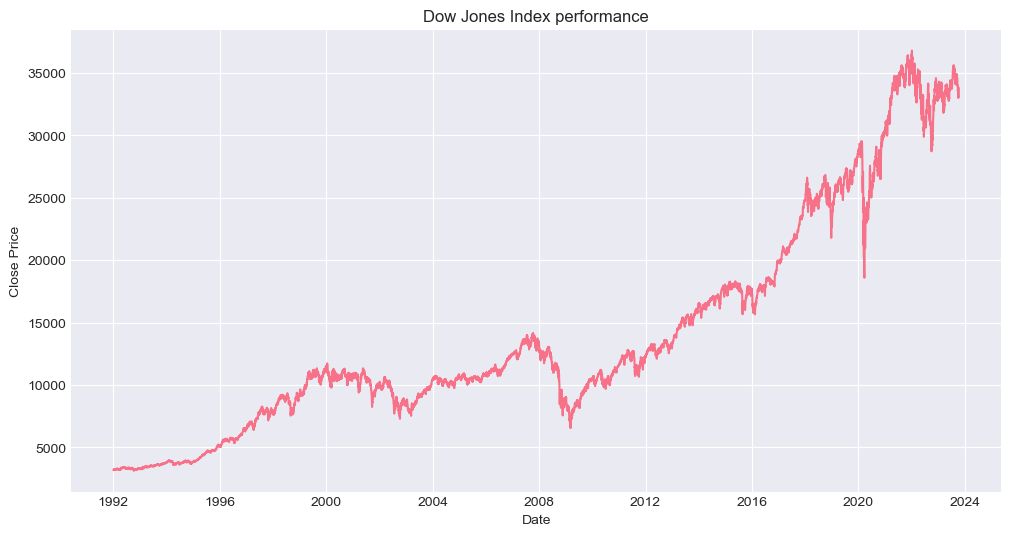

In [291]:
plt.plot(dowjones_perf.index, dowjones_perf["Close"])
plt.title("Dow Jones Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

## Inflációs adatok
Ebben a fejezetben
 - Betöltöm az adatokat
 - Elforgatom a táblázatot, hogy kezelhetőbb legyen
 - Oszlopok típusát állítom be helyesre

In [292]:
inflation_temp = pd.read_csv(data_path / 'usd_inflation.csv', parse_dates=['Year'], header=0)
inflation_temp.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ave
0,1914-01-01,2.0,1.0,1.0,0.0,2.1,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0
1,1915-01-01,1.0,1.0,0.0,2.0,2.0,2.0,1.0,-1.0,-1.0,1.0,1.0,2.0,1.0
2,1916-01-01,3.0,4.0,6.1,6.0,5.9,6.9,6.9,7.9,9.9,10.8,11.7,12.6,7.9
3,1917-01-01,12.5,15.4,14.3,18.9,19.6,20.4,18.5,19.3,19.8,19.5,17.4,18.1,17.4
4,1918-01-01,19.7,17.5,16.7,12.7,13.3,13.1,18.0,18.5,18.0,18.5,20.7,20.4,18.0


### Adatok tisztítása
 - Elforgatás

Felül látható, hogy 1 sor = 1 év 12 hónapra és azok átlaga. Ez megjelenítésre alkalmatlan, tehát elforgatom úgy, hogy 1 sorban legyen 1 hónap inflációs adata.
Egy sorban az adat dátuma (indexként), és maga az adat lesz.

In [293]:
inflation = inflation_temp.melt(
    id_vars=["Year"],
    value_vars=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    var_name="Month",
    value_name="Inflation"
)
inflation["Year"] = pd.to_datetime(inflation["Year"]).dt.year

# dátum aggregálása egy attribútumba
inflation["Date"] = pd.to_datetime(inflation["Year"].astype(str) + "-" + inflation["Month"], format="%Y-%b")
inflation = inflation[["Date","Inflation"]].sort_values("Date").reset_index(drop=True)
inflation = inflation.set_index("Date")

# azon sorok elhagyása amikhez nincs inflációs adat (2023 vége)
inflation = inflation.dropna(subset=["Inflation"])
inflation.index = inflation.index.tz_localize('America/New_York')

inflation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1316 entries, 1914-01-01 00:00:00-05:00 to 2023-08-01 00:00:00-04:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inflation  1316 non-null   float64
dtypes: float64(1)
memory usage: 20.6 KB


Az infláció és az index attribútum típusa helyes, nem hiányoznak adatok.

 - Megjelenítés ellenőrzése

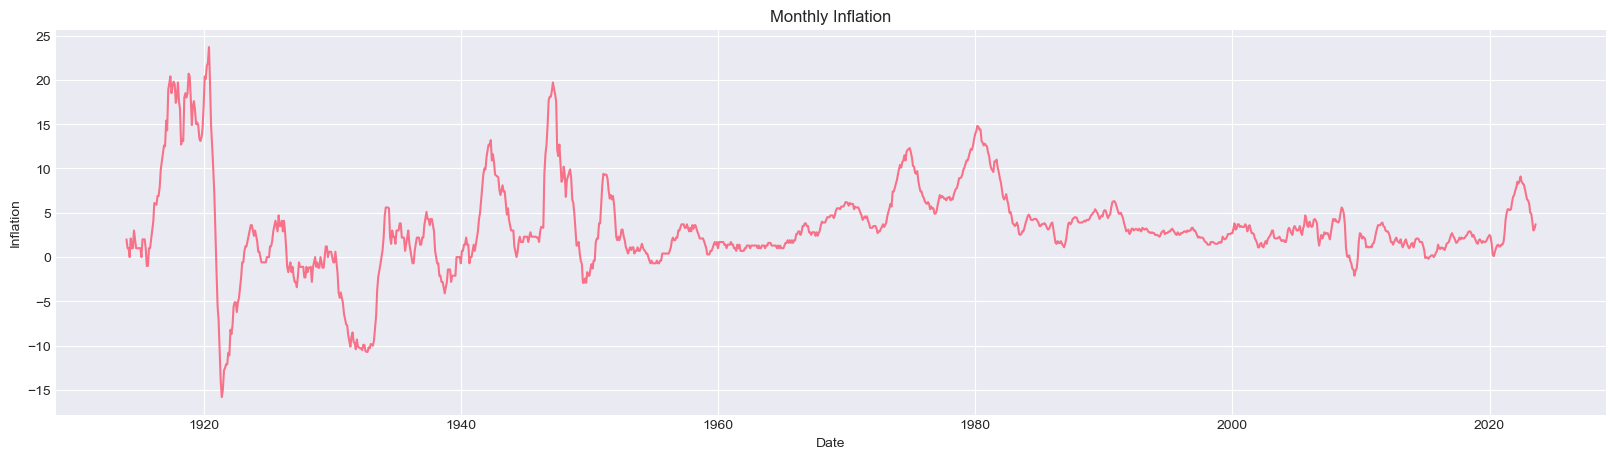

In [294]:
plt.figure(figsize=(20,5))
plt.plot(inflation.index, inflation["Inflation"])
plt.title("Monthly Inflation")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.show()

## Részvények

Ebben a fejezetben
 - Ismertetem az adatok struktúráját
 - Cikusban betöltöm az összes részvényt

### Teszt egy részvényen

In [295]:
teststock = pd.read_csv('data/usa_stocks_data/stock_prices/TSLA.csv', header=0, index_col=0)
teststock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3345 entries, 2010-06-29 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3345 non-null   float64
 1   High          3345 non-null   float64
 2   Low           3345 non-null   float64
 3   Close         3345 non-null   float64
 4   Volume        3345 non-null   int64  
 5   Dividends     3345 non-null   float64
 6   Stock Splits  3345 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 209.1+ KB


Látható, hogy az adattípusok, az indexen kívül, megfelelnek az elvártaknak, és nem hiányzik adat

 - Típus konverziók

In [296]:
teststock.index = pd.to_datetime(teststock.index, utc=True, errors="coerce")
teststock.index = teststock.index.tz_convert("America/New_York")
teststock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3345 entries, 2010-06-29 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3345 non-null   float64
 1   High          3345 non-null   float64
 2   Low           3345 non-null   float64
 3   Close         3345 non-null   float64
 4   Volume        3345 non-null   int64  
 5   Dividends     3345 non-null   float64
 6   Stock Splits  3345 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 209.1 KB


### Összes részvény adat betöltése

Ebben a fejezetben az összes részvény adatát betöltöm
   - *stocks* tömb: Összes betöltött részvény szimbóluma
   - *prices* dictionary: összes részvény adata, kulcs a részvény szimbóluma

In [297]:
folder = Path("data/usa_stocks_data/stock_prices/")

prices = {}
stocks = []

for csv_file in folder.glob("*.csv"):
    symbol = csv_file.stem  
    df = pd.read_csv(csv_file, header=0, index_col=0)

    # oszlop típus konverzió
    df.index = pd.to_datetime(df.index, utc=True, errors="coerce")
    df.index = df.index.tz_convert("America/New_York")

    stocks.append(symbol)
    prices[symbol] = df

- Ellenőrzés

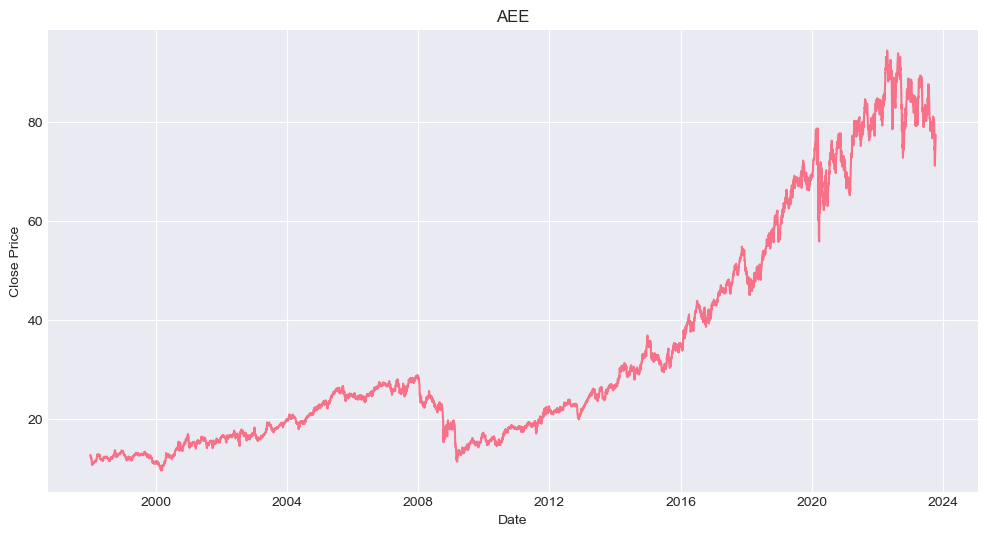

In [298]:
current_stock = stocks[13]
plt.plot(prices[current_stock].index, prices[current_stock]["Close"])
plt.title(current_stock)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


# Adatok vizsgálata

Ebben a fejezetben az EDA utolsó lépései következnek, a betöltött adatok alapvető tulajdonságainak vizsgálata

## Idősorok vizsgálata

Megvizsgálom, hogy az adatok milyen részletességgel és meddigre visszamenőleg állnak rendelkezésre adatok
### Indexek

In [299]:
indeces = {
    'S&P 500': sp500_perf,
    'Nasdaq 100': nasdaq100_perf,
    'Dow Jones': dowjones_perf
}
data_list = []

for name, idx in indeces.items():
    start = idx.index.min().date()
    end = idx.index.max().date()
    duration = round((end - start).days / 365, 1)
    delta = idx.index.to_series().diff().value_counts().sort_index()     ## részletesség meghatározása


    data_list.append({
        'Index neve': name,
        'Kezdet': start,
        'Vége': end,
        'Időtartam (év)': duration,
        'Adatpontok száma': len(idx),
        'Részletesség (nap)': min(delta)
    })


df_summary = pd.DataFrame(data_list)
df_summary.set_index('Index neve', inplace=True)

display(df_summary)

,Kezdet,Vége,Időtartam (év),Adatpontok száma,Részletesség (nap)
Index neve,,,,,
S&P 500,1927-12-30,2023-10-11,95.8,24060,1
Nasdaq 100,1985-10-01,2023-10-11,38.1,9585,1
Dow Jones,1992-01-02,2023-10-11,31.8,8004,1


Látható, hogy az összes index napi részletességgel van jelen, az indexek közül, pedig az S&P 500 messze a legrégebbi, majd ezt a 80-as években bejegyzett Nasdaq 100, és a 90-es években létrehozott Dow Jones követi.

### Részvények

Összesen 1 különböző részletesség van az adatokban : [1] (nap)


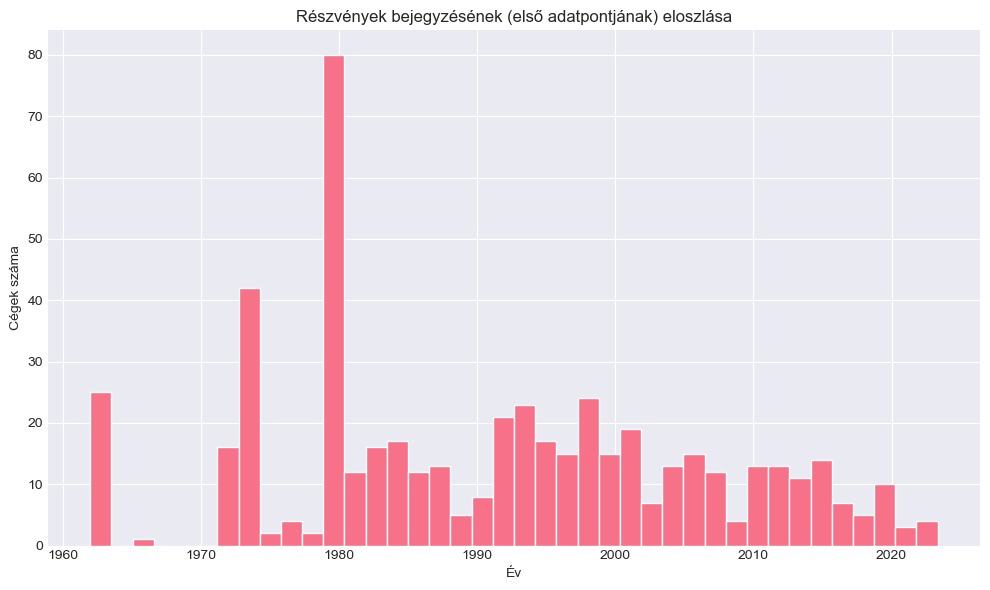

In [300]:
ipo = []
deltas = set()

for ticker, idx in prices.items():
    if not idx.empty:
        ipo.append(idx.index.min())

        delta = idx.index.to_series().diff().value_counts() # részletesség meghatározása
        most_frequent_delta = delta.idxmax().days  # leggyakoribb részletesség meghatározása
        deltas.add(most_frequent_delta)

print(f"Összesen {len(deltas)} különböző részletesség van az adatokban : {list(deltas)} (nap)")

#Hisztogram
plt.figure(figsize=(10, 6))
plt.hist(ipo, bins=40)

plt.title('Részvények bejegyzésének (első adatpontjának) eloszlása')
plt.xlabel('Év')
plt.ylabel('Cégek száma')

plt.tight_layout()
plt.show()

## Szektorok eloszlása

Itt megvizsgálom a szektorokban található cégek számát, ami a későbbi klaszterezésnél fontos lehet.


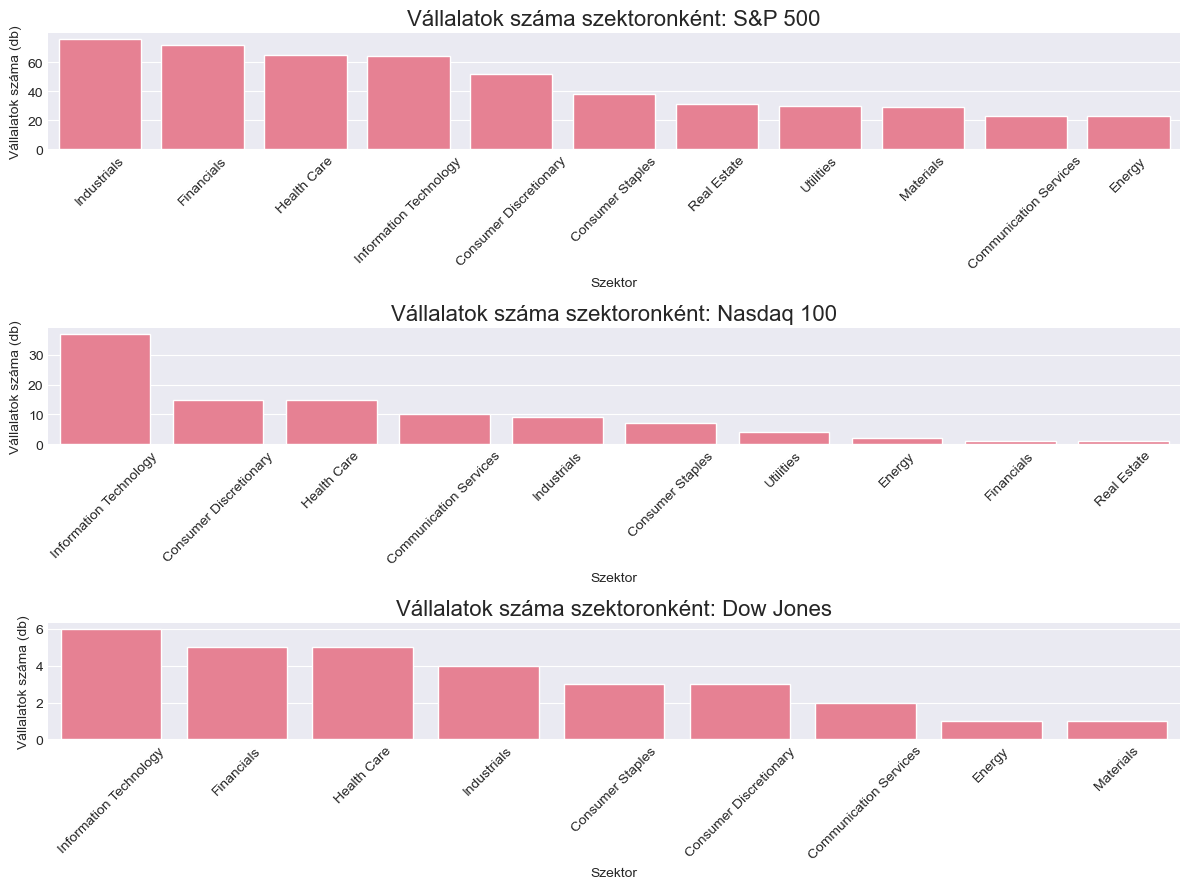

In [301]:
indeces_constituents = {
    'S&P 500': sp500_companies,
    'Nasdaq 100': nasdaq100_companies,
    'Dow Jones': dowjones_companies
}

fig, axs = plt.subplots(3, 1, figsize=(12, 9))

for i, (name, idx) in enumerate(indeces_constituents.items()):
    sector_counts = idx['Sector'].value_counts().sort_values(ascending=False)  ## szektorokhoz tartozó cégek számának kinyerése
    sns.barplot(x=sector_counts.index, y=sector_counts.values, ax=axs[i])   ## megjelenítés
    axs[i].set_title(f"Vállalatok száma szektoronként: {name}", fontsize=16)
    axs[i].set_xlabel('Szektor')
    axs[i].set_ylabel('Vállalatok száma (db)')
    axs[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Megfigyelések:

Nasdaq-100: Az ábrán látható, hogy a Nasdaq-100 indexet az Information Technology szektor dominálja.

S&P 500: Az S&P 500 esetében sokkal egyenletesebb a szektorok eloszlása. Ez indokolja, hogy miért ezt az indexet tekintjük a piac általános "benchmarkjának".

Dow Jones korlátai: A Dow Jones mindössze 30 vállalatot tartalmaz, így itt bizonyos szektorok (pl. Real Estate vagy Utilities) teljesen hiányozhatnak. Ezért a klaszterezési algoritmusoknál a Dow Jones adataitól várhatjuk a legkevesebb "zajt", de a legkisebb statisztikai reprezentativitást is

## Indexek hozama
### Éves hozamok

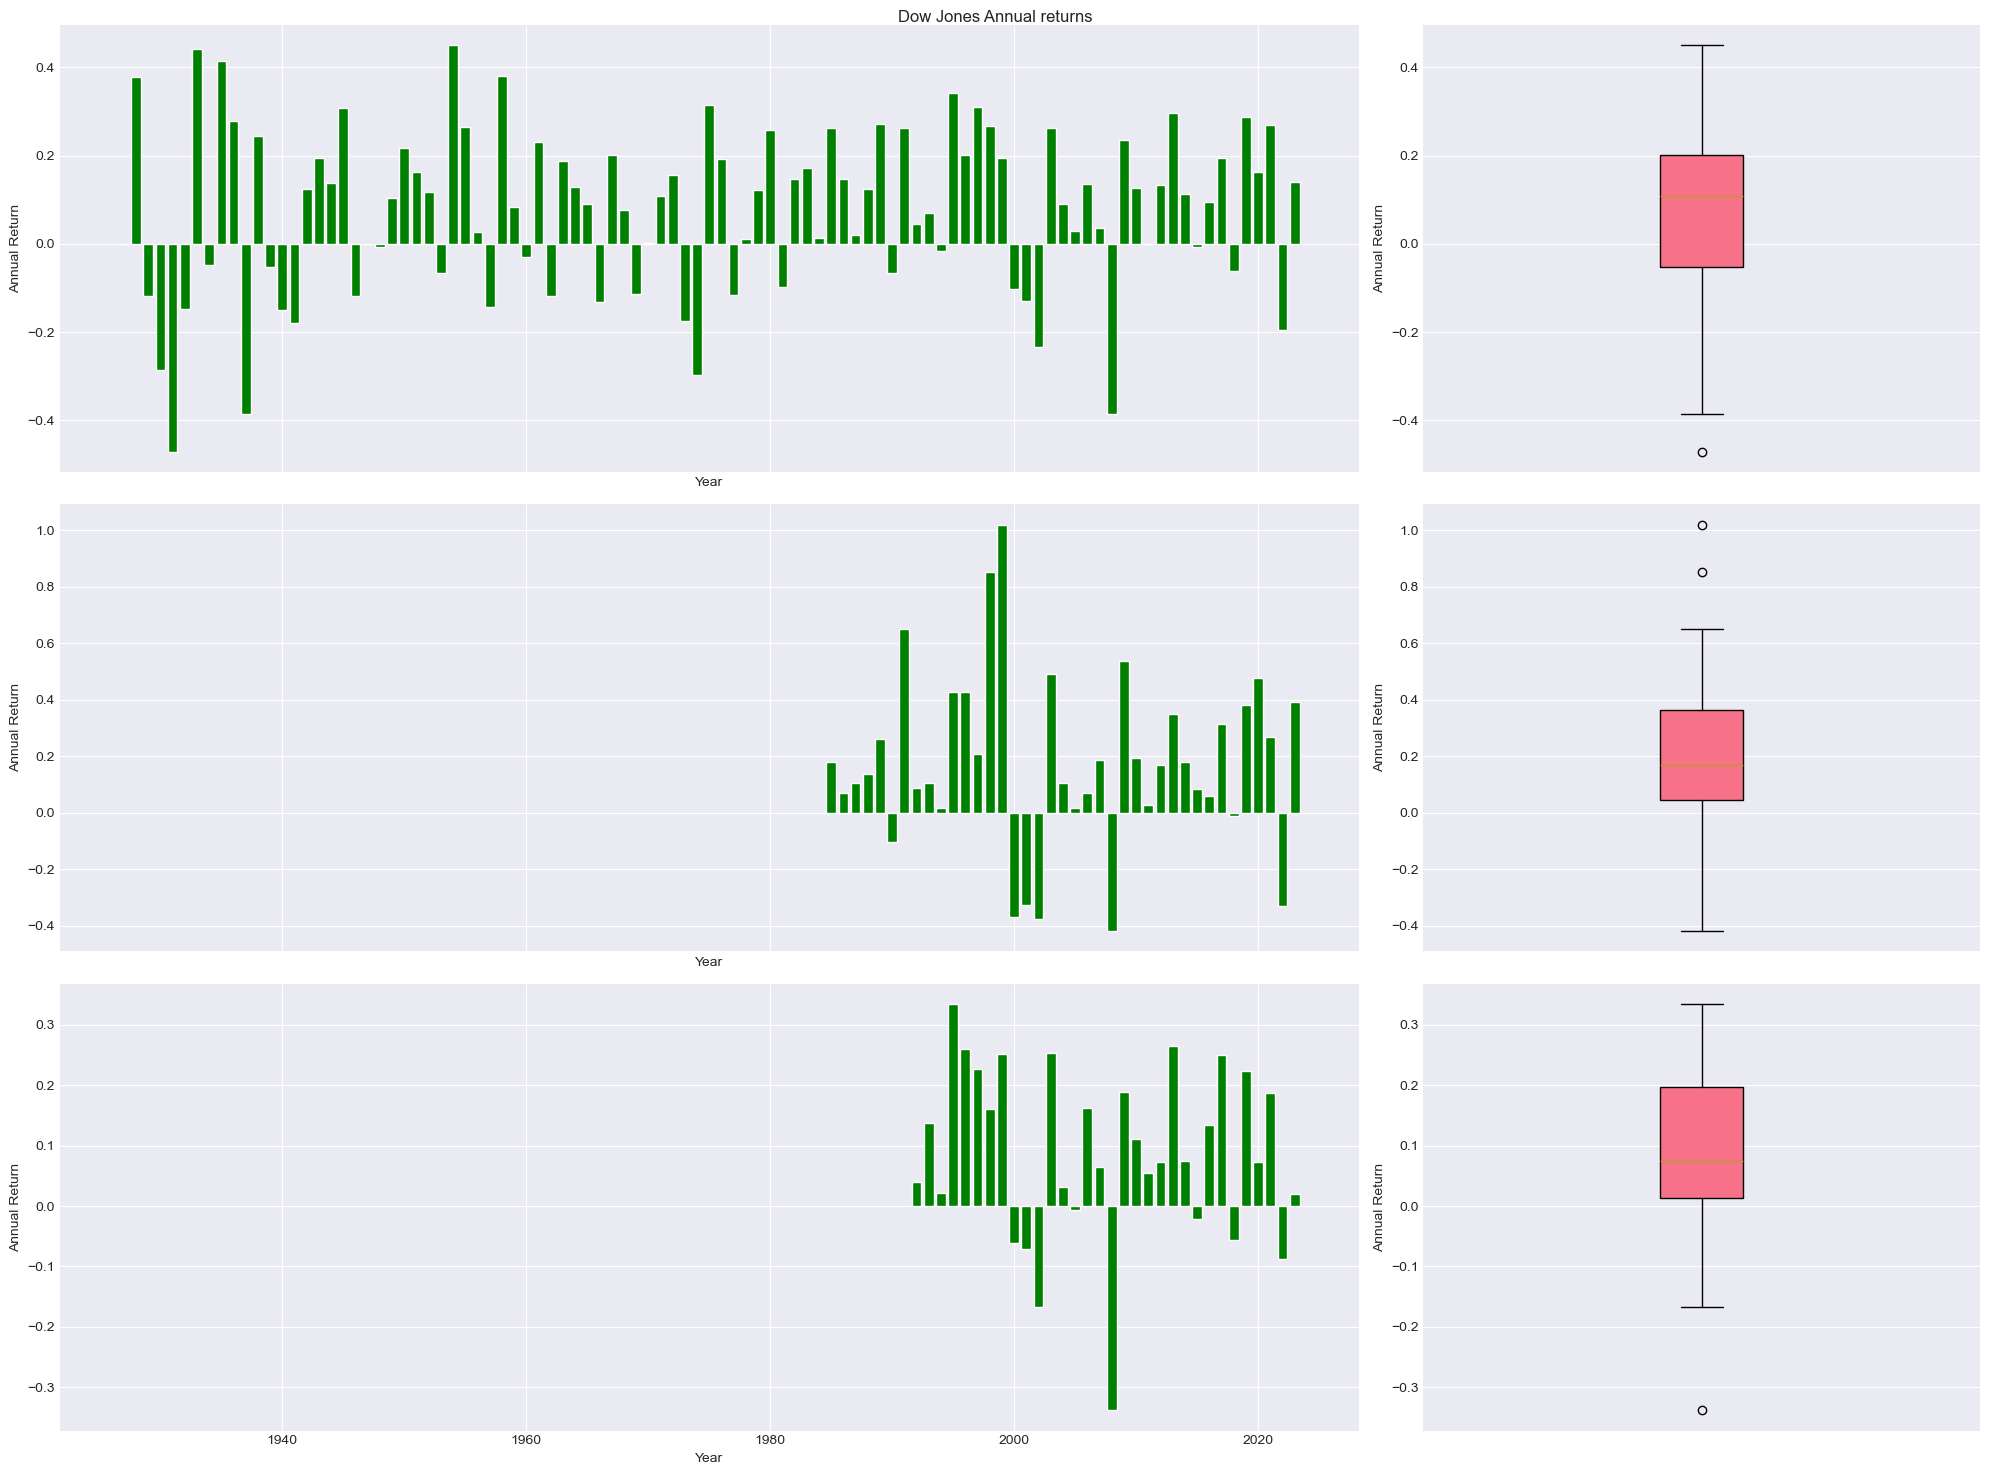

In [302]:
fig, axs = plt.subplots(3, 2, figsize=(20,15), gridspec_kw={'width_ratios': [7, 3]}, sharex='col')

for i, (name, idx) in enumerate(indeces.items()):
    idx['Return'] = idx['Close'].pct_change() ## napi hozam meghatározása
    annual_return = (1 + idx['Return']).resample('YE').prod() - 1 ## éves hozam meghatározása

    ## grafikonok megjelenítése
    fig.suptitle(f"{name} Annual returns")

    axs[i,0].bar(annual_return.index.year, annual_return.values, color='green')
    axs[i,0].set_xlabel("Year")
    axs[i,0].set_ylabel("Annual Return")
    axs[i,0].grid(True, axis='y')

    axs[i,1].boxplot(annual_return.values, vert=True, patch_artist=True)
    axs[i,1].set_ylabel("Annual Return")
    axs[i,1].set_xticks([])
    axs[i,1].grid(True, axis='y')

plt.tight_layout()
plt.show()

Általános tendenciák:
- A három index hosszú távon pozitív hozamot mutat, bár jelentős évenkénti ingadozásokkal.
- A boxplotok mutatják, hogy az éves hozamok eloszlása aszimmetrikus: több pozitív év van, mint negatív, ami a részvénypiac hosszú távú növekedési trendjét tükrözi.

Index-specifikus megfigyelések:
- S&P 500: A leghosszabb idősorral rendelkezik (1927-től), így tartalmazza a legtöbb történelmi eseményt (pl. 1929-es válság, olaj-válság, 2008-as pénzügyi válság). A volatilitás a boxplot alapján viszonylag stabil.
- Nasdaq 100: Technológiai orientációja miatt általában magasabb volatilitást mutat, és gyakran erősebb növekedési periódusokat mutat (pl. dot-com buborék, 2020-as tech rally).
- Dow Jones: A legrövidebb idősorral rendelkezik (1992-től), de a 30 nagyvállalat összetétele miatt általában stabilabb hozamokat mutat.

Kockázati tényezők:
- A negatív évek (pl. 2008, 2022) mindhárom indexnél egyértelműen láthatók, és gyakran makrogazdasági válságokhoz köthetők.


### Hozamok eloszlása

A következő cella a napi hozamok eloszlását ábrázolja a ferdeség és csúcsosság értékeivel együtt.

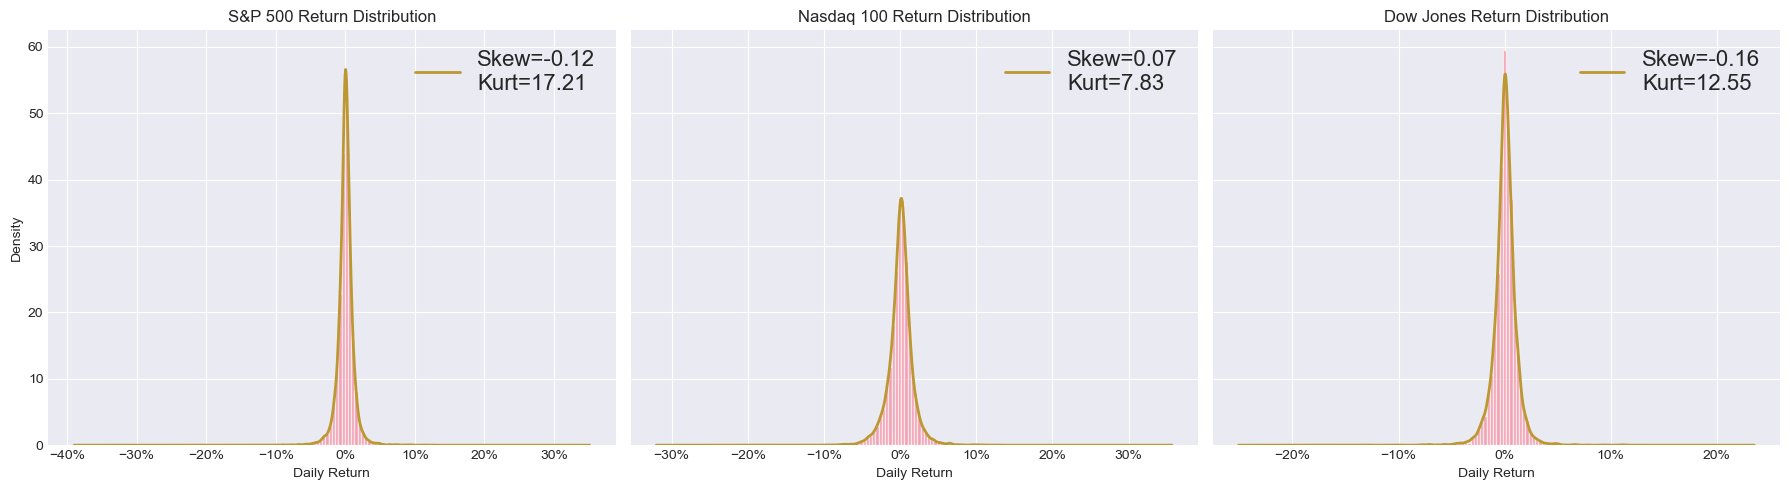

In [303]:
returns = pd.DataFrame({
    'S&P 500': sp500_perf['Return'].dropna(),
    'Nasdaq 100': nasdaq100_perf['Return'].dropna(),
    'Dow Jones': dowjones_perf['Return'].dropna()

})

fig, ax = plt.subplots(1, 3, figsize=(18,5), sharey=True)
for i, name in enumerate(returns.columns):
    ## skew, kurtosis kiszámítása
    skew = returns[name].skew()
    kurt = returns[name].kurtosis()

    ## grafikonok
    ax[i].hist(returns[name], bins=80, density=True, alpha=0.6)

    returns[name].plot(kind='kde', ax=ax[i], linewidth=2, label=f'Skew={skew:.2f}\nKurt={kurt:.2f}')

    ax[i].set_title(f"{name} Return Distribution")
    ax[i].set_xlabel("Daily Return")
    ax[i].set_ylabel("Density")
    ax[i].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax[i].legend(fontsize=16)

plt.tight_layout()
plt.show()

A negatív ferdeség (S&P 500, DOW) tipikus a pénzügyi piacokon, mivel a pánik és a nagy eladási hullámok általában gyorsabbak és mélyebbek, mint a hosszan tartó, stabil emelkedések. Mindhárom index hozama *leptokurtikus* mivek csúcsosság mindegyiknél nagyobb mint 3, ami jellemző a pénzügyi adatokra. Ez azt jelenti, hogy az 'extrém' értékeknek nagyobb esélyük van.

S&P 500 mutatja a legnagyobb kockázatot a szélsőséges események szempontjából, mivel az ő csúcsossága a legmagasabb (17.25).

Mind a S&P 500, mind a DOW enyhe baloldali ferdeséget mutat, ami azt jelzi, hogy a nagy negatív meglepetések valószínűbbek, mint a nagy pozitív meglepetések.

A NASDAQ hozamai állnak a legközelebb a szimmetrikus eloszláshoz, de a magas csúcsosság (7.83) itt is figyelmeztet a ritka, de potenciálisan súlyos események kockázatára.

## Indexek korrelációja

In [304]:
returns = pd.DataFrame({
    'S&P 500': sp500_perf['Return'].dropna(),
    'Nasdaq 100': nasdaq100_perf['Return'].dropna(),
    'Dow Jones': dowjones_perf['Return'].dropna()

})

#korreláció meghatározása, felesleg elhagyása
corr_pairs = returns.corr().unstack()
unique_pairs = corr_pairs[corr_pairs < 1].drop_duplicates()

print("Indexek közötti korreláció:")

for (i, j), val in unique_pairs.items():
    print(f"{i} <-> {j} : {val:.3f}")

Indexek közötti korreláció:
S&P 500 <-> Nasdaq 100 : 0.837
S&P 500 <-> Dow Jones : 0.962
Nasdaq 100 <-> Dow Jones : 0.748


 - S&P 500 - Dow Jones: 0.962 Ez majdnem tökéletes korreláció, ami a nagy átfedésnek, és a két index hasonló felépítésének köszönhető.
 - S&P 500 - Nasdaq 100: 0.837 Ez már nem olyan magas mint az előbb, de még mindig erős. Ez a különbség részben magarázható azzal, hogy a Nasdaq inkább tech súlyú.
 - Nasdaq 100 - Dow Jones: 0.748: Ez a legkisebb, de azért még midnig erős korreláció. Ez is azzal magyarázható, hogy a nasdaq főleg technológiai,Ez a különbség részben magarázható azzal, hogy a Nasdaq inkább tech súlyú, a Dow pedig inkább hagyományos ipari, és blue chip cégeket tartalmaz.
 - Domináns piaci trend: Az összes érték 0,7 feletti, ami egyértelműen erős kapcsolatot jelent, így egy általános piaci esés esetén az indexek közötti diverzifikáció csak korlátozott védelmet nyújt.

## Részvények korrelációja
Ebben a fejezetben megvizsgálom a részvények közti korrelációk eloszlását

Logaritmikus hozam: Előnyös, mert az adatok időben összeadhatóak, és jobban közelítik a statisztikai számításokhoz szükséges normális eloszlást. Emellett kiküszöböli a százalékos számítás torzítását, így szimmetrikusan és pontosabban kezeli a nagy arányú áreséseket és emelkedéseket.


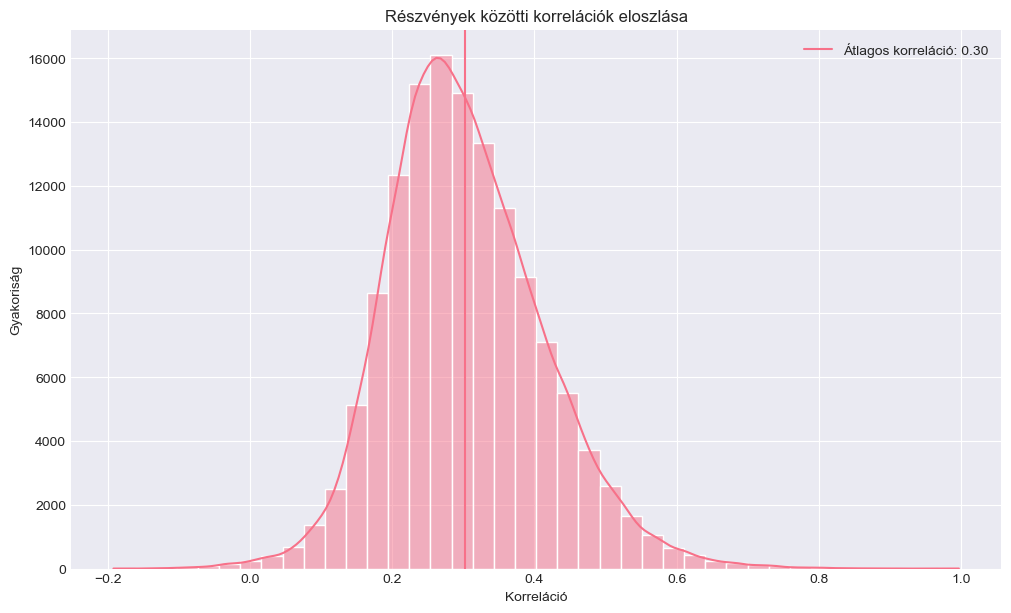

In [305]:
close_prices = pd.DataFrame({symbol: df['Close'] for symbol, df in prices.items()})

returns_stocks = np.log(close_prices / close_prices.shift(1))
##Páronkénti korreláció, mert minden részvény különböző pontban lett listázva (nem lehet dropna)
corr_matrix = returns_stocks.corr()

# Adatok tisztítása (csak a főátló feletti értékek)
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_values = corr_matrix.where(mask).stack()


#grafikon
plt.figure(figsize=(12, 7))
sns.histplot(corr_values, bins=40, kde=True)

plt.axvline(corr_values.mean(), label=f'Átlagos korreláció: {corr_values.mean():.2f}')

plt.title('Részvények közötti korrelációk eloszlása')
plt.xlabel('Korreláció')
plt.ylabel('Gyakoriság')
plt.legend()

plt.show()

 - Pozitív piaci együttmozgás: Az adatok egyértelműen pozitív eltolódást mutatnak, ahol a korrelációk átlaga 0.30, ami jelzi, hogy a részvények többsége hajlamos egyszerre, azonos irányba mozogni.
 - Diverzifikációs potenciál: Bár a legtöbb érték a 0.1 és 0.5 közötti tartományba esik, a bal oldali farok jelenléte lehetőséget ad a kockázatcsökkentő portfólióépítésre.

Észrevételek:
 - Csoportosulás: Az, hogy a korrelációk ilyen szűk sávban csoportosulnak, lehetőséget ad arra, hogy a csoprotokat tovább vizsgáljam a későbbiekben.
 - Kiugró értékek: Későbbi vizsgálat során érdemes lehet megvizsgálni a 0.1 alatti, 0.5 feletti értékeket.
 - Stabilitás: A későbbi elemzésnél érdemes lesz vizsgálni, hogy ez a 0.30-as átlag hogyan változik piaci stressz idején.

## Legmagasabb és legalacsonyabb hozamú évek


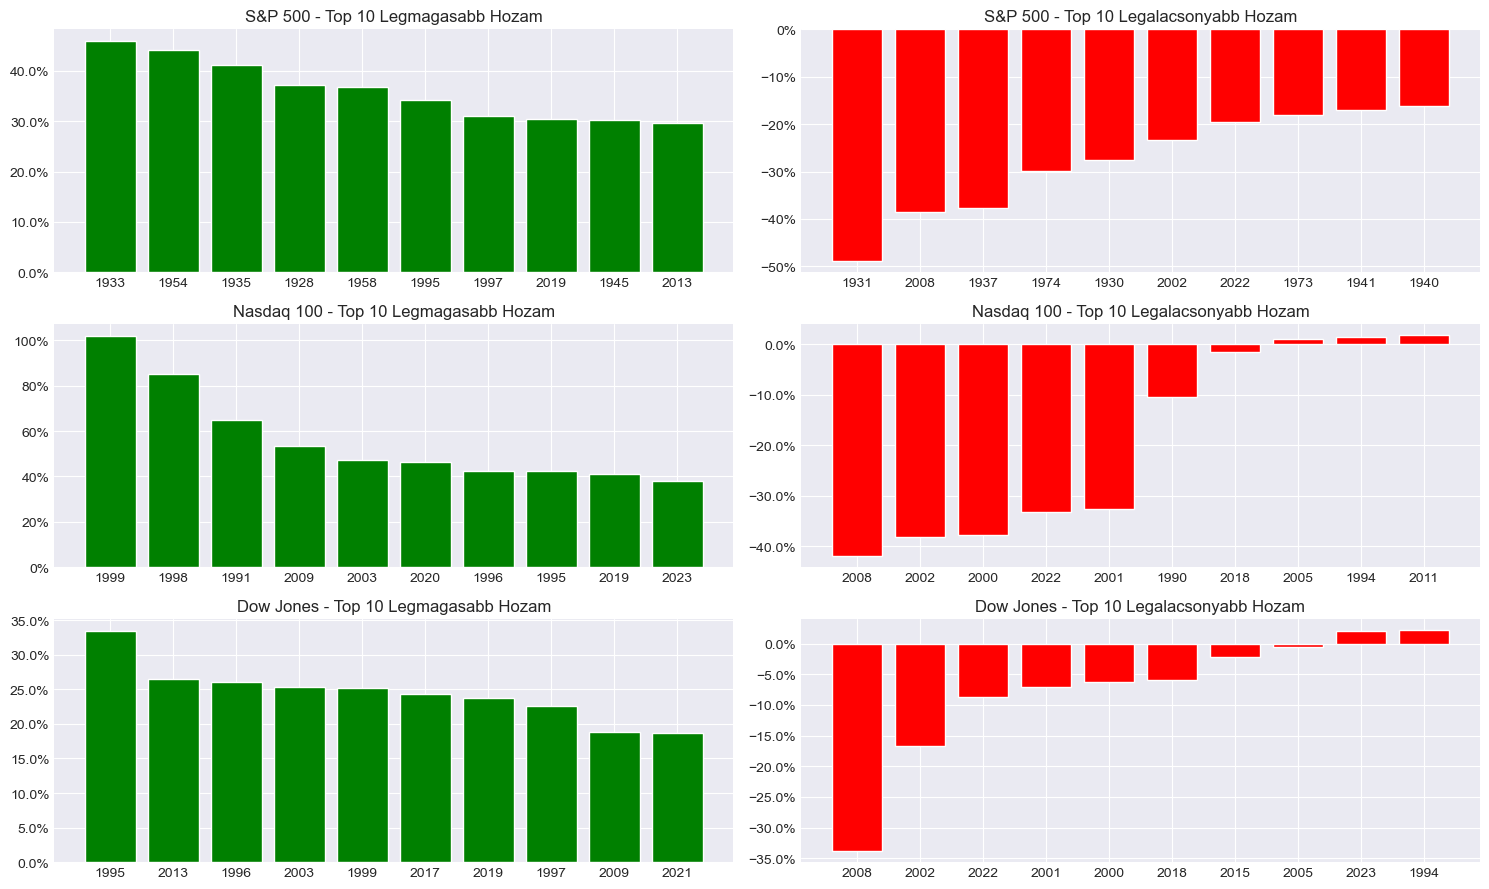

In [306]:
top_n = 10
yearly_return = {}

for name, idx in indeces.items():
    annual_return = {}
    # évek szerinti csoportosítás a teljes adatsoron
    for year, group in idx.groupby(idx.index.year):
        open_price = group.iloc[0]['Open'] if group.iloc[0]['Open'] != 0 else group.iloc[0]['Close']    # Az év első nyitóára (ha 0, akkor a zárót használjuk)
        close_price = group.iloc[-1]['Close']                                                           # Az év utolsó záróára

        if pd.notna(open_price) and pd.notna(close_price):
            annual_return[year] = (close_price - open_price) / open_price                               # Éves hozam kiszámítása: (Záró - Nyitó) / Nyitó

    yearly_return[name] = pd.Series(annual_return).dropna()

# Grafikonok létrehozása (Indexek száma x 2 oszlop)
fig, axs = plt.subplots(3, 2, figsize=(15, 9))

for i, (idx_name, returns) in enumerate(yearly_return.items()):
    top_highest = returns.nlargest(top_n).sort_values(ascending=False)                  # A 10 legnagyobb és 10 legkisebb érték kiválasztása
    top_lowest = returns.nsmallest(top_n).sort_values(ascending=True)

    # Legjobbak
    ax_high = axs[i][0]                                                                 # Bal oldal: A 10 legjobb év (Zöld)
    ax_high.bar(top_highest.index.astype(str), top_highest.values, color='green')
    ax_high.set_title(f"{idx_name} - Top {top_n} Legmagasabb Hozam")
    ax_high.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    # Legrosszabbak
    ax_low = axs[i][1]                                                                  # Jobb oldal: A 10 legrosszabb év (Piros)
    ax_low.bar(top_lowest.index.astype(str), top_lowest.values, color='red')
    ax_low.set_title(f"{idx_name} - Top {top_n} Legalacsonyabb Hozam")
    ax_low.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.tight_layout()
plt.show()

Az ábrán látható, hogy a Nasdaq 100 a legvolatilisebb (100% feletti csúcs és sűrűbb -30% alatti évek), míg a Dow Jones a legstabilabb index. A legrosszabb évek listáján több pozitív hozamú év is szerepel, ami jelzi, hogy a tőzsdén a növekedés az uralkodó irány. A grafikonokon jól láthatóak a történelmi válságok (világválság, dotcom crash, 2008-as gazdasági válság) egységesen negatív hatásai.

## Inflációs adatok eloszlása

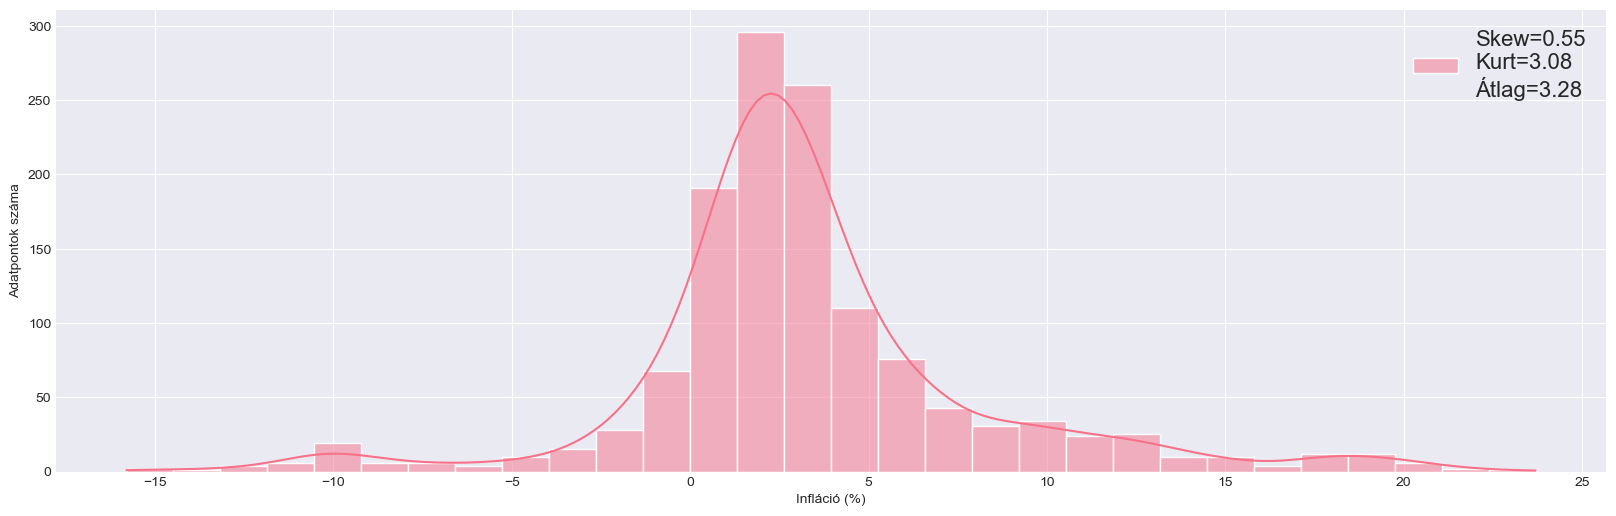

In [307]:
# leíró statisztikák
skew = inflation['Inflation'].skew()
kurt = inflation['Inflation'].kurtosis()
mean = inflation['Inflation'].mean()


# Eloszlás vizualizációja
plt.figure(figsize=(20,6))
sns.histplot(inflation['Inflation'], bins=30, kde=True, label=f'Skew={skew:.2f}\nKurt={kurt:.2f}\nÁtlag={mean:.2f}')
plt.xlabel("Infláció (%)")
plt.ylabel("Adatpontok száma")
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

Ferdeség: 0.55 : A pozitív ferdeség azt jelenti, hogy az eloszlás enyhén jobbra húzódik, azaz a leggyakoribb inflációs értékek a medián alatt helyezkednek el, és az eloszlásnak van egy hosszabb "farka" a magas infláció irányába, tehát a ritkán előforduló, extrém magas inflációs sokkok valószínűbbek voltak, mint az extrém deflációs sokkok.

Csúcsosság: 3.08 :  A 3.08 érték azt jelenti, hogy az eloszlás nagyon közel áll a normál eloszláshoz. Az enyhén 3 feletti érték azt jelzi, hogy az infláció a középpontban enyhén csúcsosabb, és a szélső értékek is enyhén gyakoribbak, mint amit a normál eloszlás feltételezne.

# Hipotézisek

## Az indexek hozama nem autokorrelál

Amióta érdekel ez a téma, a kereskedési stratégiákról gyakran olyan kontextusban olvasok, ahol az egyik kulcsmondat az, hogy *"past performance is not indicative of future results"*. Tehát ha egy stratégia backtest-en rendkívüli hozamot tud elérni, az nem garantálja, hogy ez a jövőben is így lesz.
Statisztikai értelemben ez azt jelenti, hogy a hozamok időben nem mutatnak autokorrelációt:  a mai hozam nem függ a tegnapi vagy korábbi hozamoktól.
A következő grafikon ezt a hipotézist vizsgálja, és azt próbálja igazolni, hogy a hozamok „emlékezet nélküliek”.


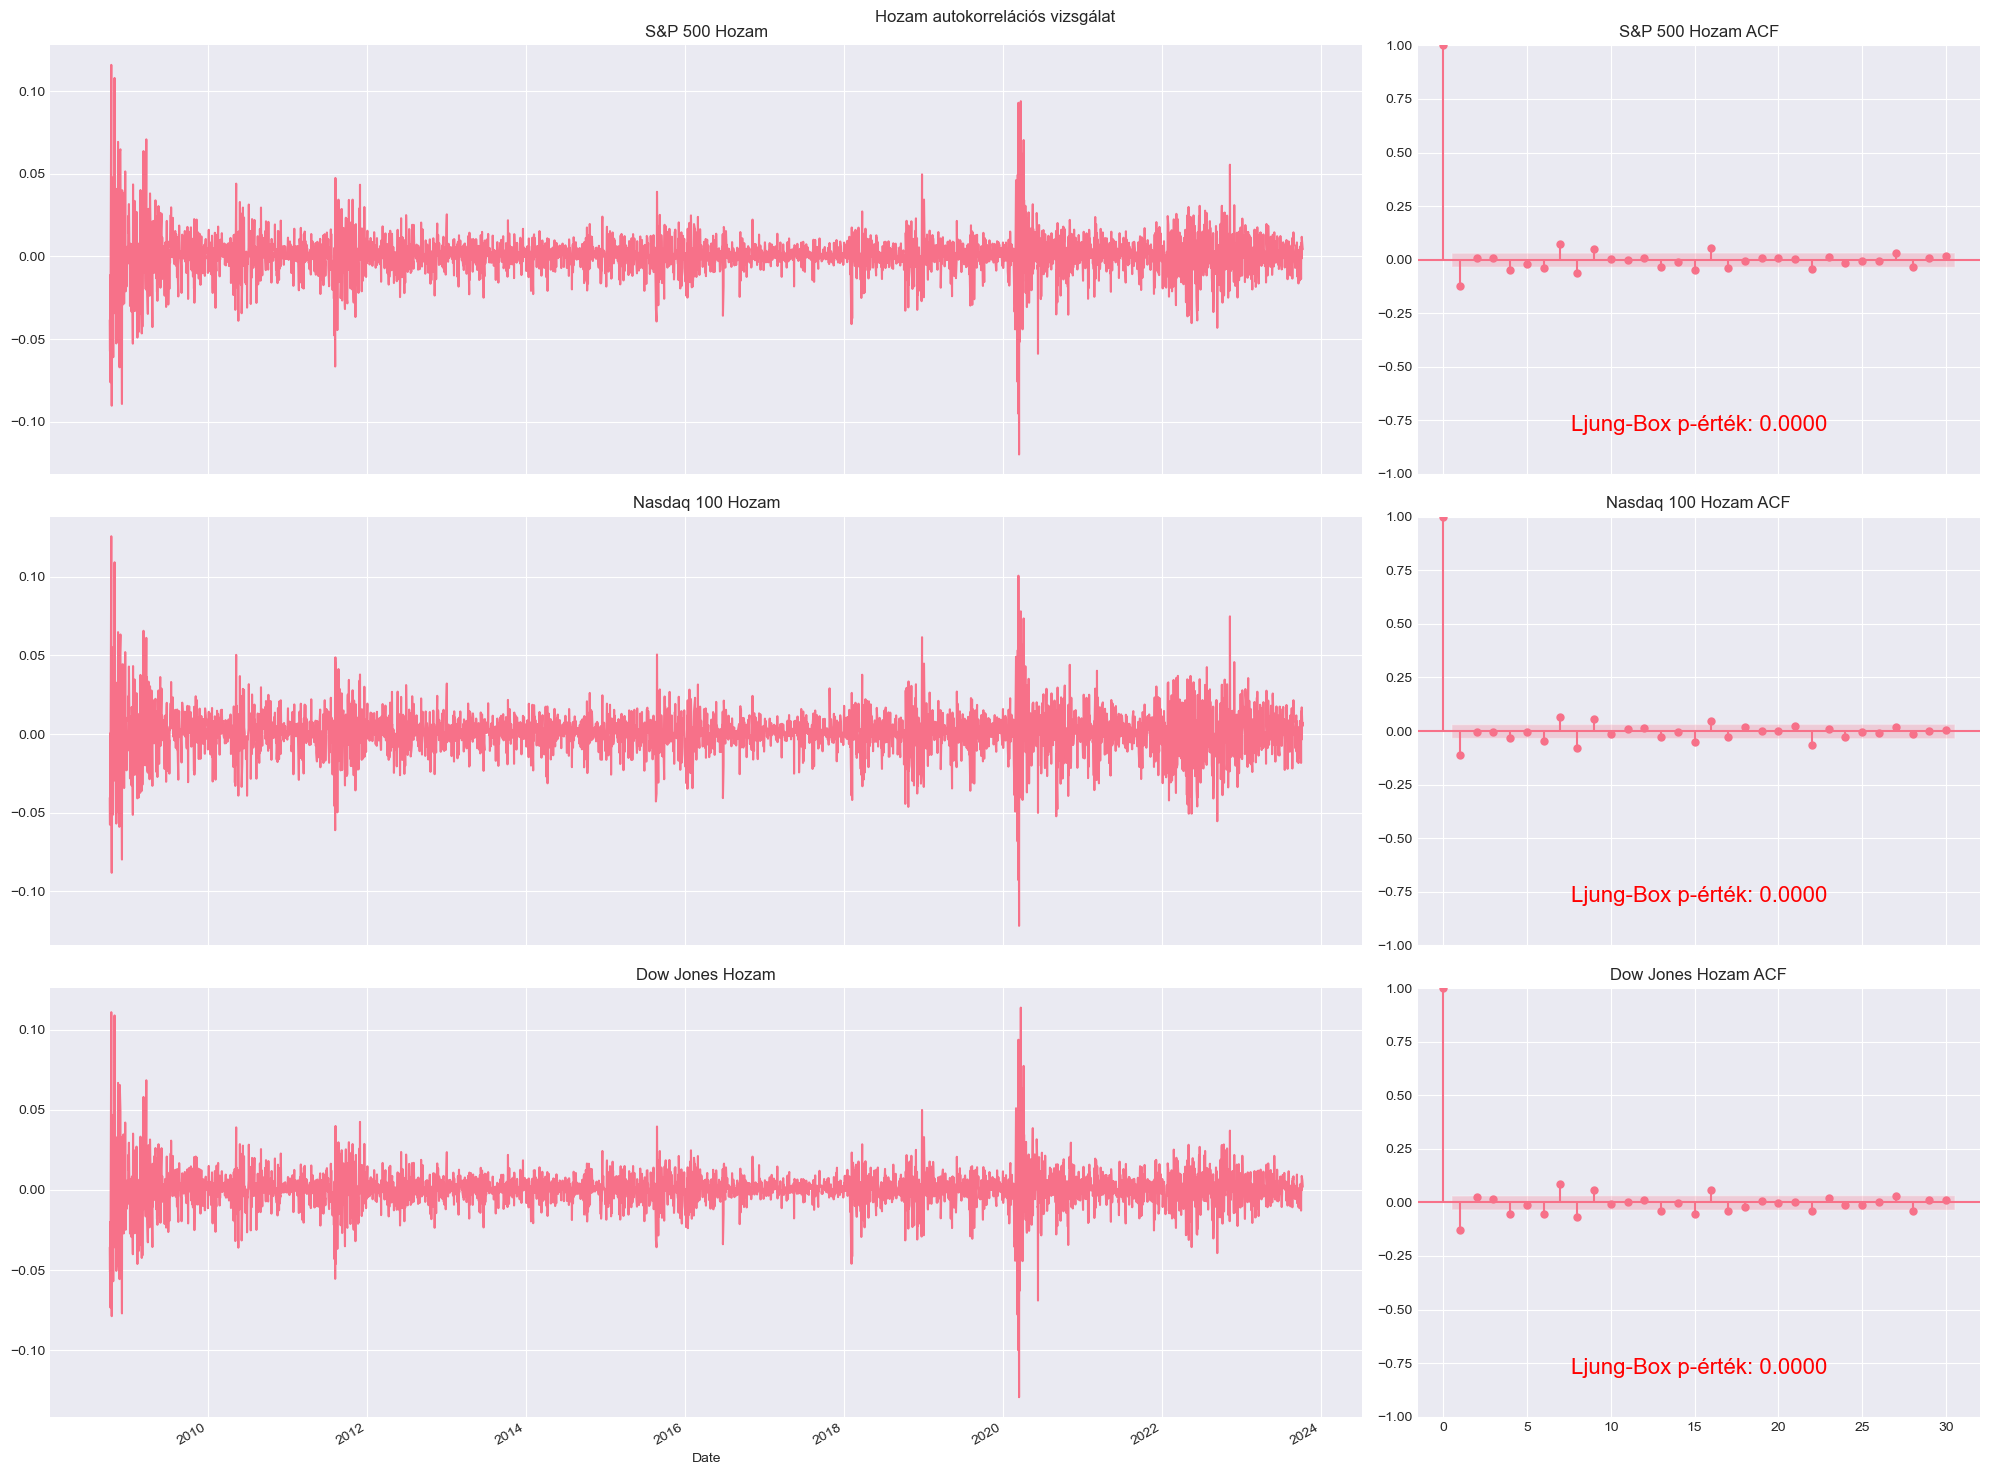

In [308]:
# Vizsgált időtáv meghatározása (utolsó 15 év)
lookback_days = 252*15
lag_to_test = 10

# Ábrák létrehozása: bal oldalon az idősor, jobb oldalon az ACF
fig, axs = plt.subplots(len(indeces), 2, figsize=(20, 15), gridspec_kw={'width_ratios': [7, 3]}, sharex='col')
fig.suptitle("Hozam autokorrelációs vizsgálat")

for i, (name, idx) in enumerate(indeces.items()):
    data = idx['Return'].iloc[-lookback_days:].dropna()         # Adatok tisztítása és ablakozása

    # Grafikon rajzolása
    data.plot(ax=axs[i,0])
    axs[i,0].set_title(f"{name} Hozam")
    plot_acf(data, lags=30, ax=axs[i,1])

    # Ljung-Box teszt lefuttatása a megadott késleltetésig
    lb_test = acorr_ljungbox(data, lags=lag_to_test, return_df=True)
    p_value = lb_test['lb_pvalue'].iloc[0]

    # p-érték megjelenítése a grafikonon
    axs[i,1].text(0.5, 0.1, f"Ljung-Box p-érték: {p_value:.4f}", transform=axs[i,1].transAxes, ha="center", color="red", fontsize=16)
    axs[i,1].set_title(f"{name} Hozam ACF")

plt.tight_layout()
plt.show()

A bal oldali ábra az idősor tényleges, százalékos hozamait mutatja, időben egymás után.
Ez alapján látható, hogy a hozamok ingadoznak, de vizuálisan nem látszik tartós trend vagy ismétlődő mintázat.

A jobb oldali ábra ugyanezen hozamok ACF-je. Először azt hittem, hogy mivel az ingadozások kicsinek tűntek ez elég arra, hogy belássam a hipotézisem helyességét, de LLM segítségével ráakadtam a Ljung-Box tesztre. Azonban a Ljung-Box teszt statisztikai eredménye végül felülírta ezt a kezdeti vizuális benyomást. Míg az ACF grafikon oszlopai egyenként kicsinek tűnhetnek, a teszt az első 10 késleltetett érték együttes hatását vizsgálja. A számított p-érték messze elmarad a kritikus 0,05-ös szignifikanciaszinttől, tehát a nullhipotézist elutasítom.

Miután utánaolvastam a témának, rájöttem, hogy az indexek esetében a szignifikáns autokorreláció egy jól ismert statisztikai jelenség, amelyet gyakran "Index vs. Stock" paradoxonként emlegetnek
 - A paradoxon lényege: Míg az egyedi részvények gyakran negatív autokorrelációt mutatnak a vételi és eladási árak közötti ugrálás („bid-ask bounce”) miatt, addig a piaci indexeknél gyakran pozitív autokorreláció figyelhető meg.
 - Piaci súrlódások hatása: Ez a pozitív autokorreláció általában nem jósolható trendeket jelent, hanem olyan piaci mechanizmusok eredménye, mint a nem szinkronizált kereskedés. Ha az index bizonyos elemeivel (például kisebb papírokkal) ritkábban kereskednek, azok „elavult” árai statisztikai korrelációt visznek az index számításába.
 - Információterjedés: A nagy kapitalizációjú részvények azonnal reagálnak a hírekre, míg a kisebb szektortársaknál ez a folyamat lassabb lehet, ami egyfajta mesterséges autokorrelációt okoz az index szintjén.
 - Hatékonyság és költségek: Fontos megjegyezni, hogy bár a statisztikai szignifikancia elutasítja a fehér zaj hipotézist, a gyakorlatban a tranzakciós költségek általában semmissé teszik az ebből adódó esetleges profitot, így a piac továbbra is hatékonynak tekinthető.

## Az indexek volatilitása autokorrelál

A hozammal ellentétben a volatilitás nem határoz meg irányt, tehát nem lehet része az árnak (legalábbis részvények esetén; más pénzpiaci termékeknél lehet közvetlen hatása). Feltevésem, hogy magasabb volatilitású időszakot jellemzően további magas volatilitású időszak követi.


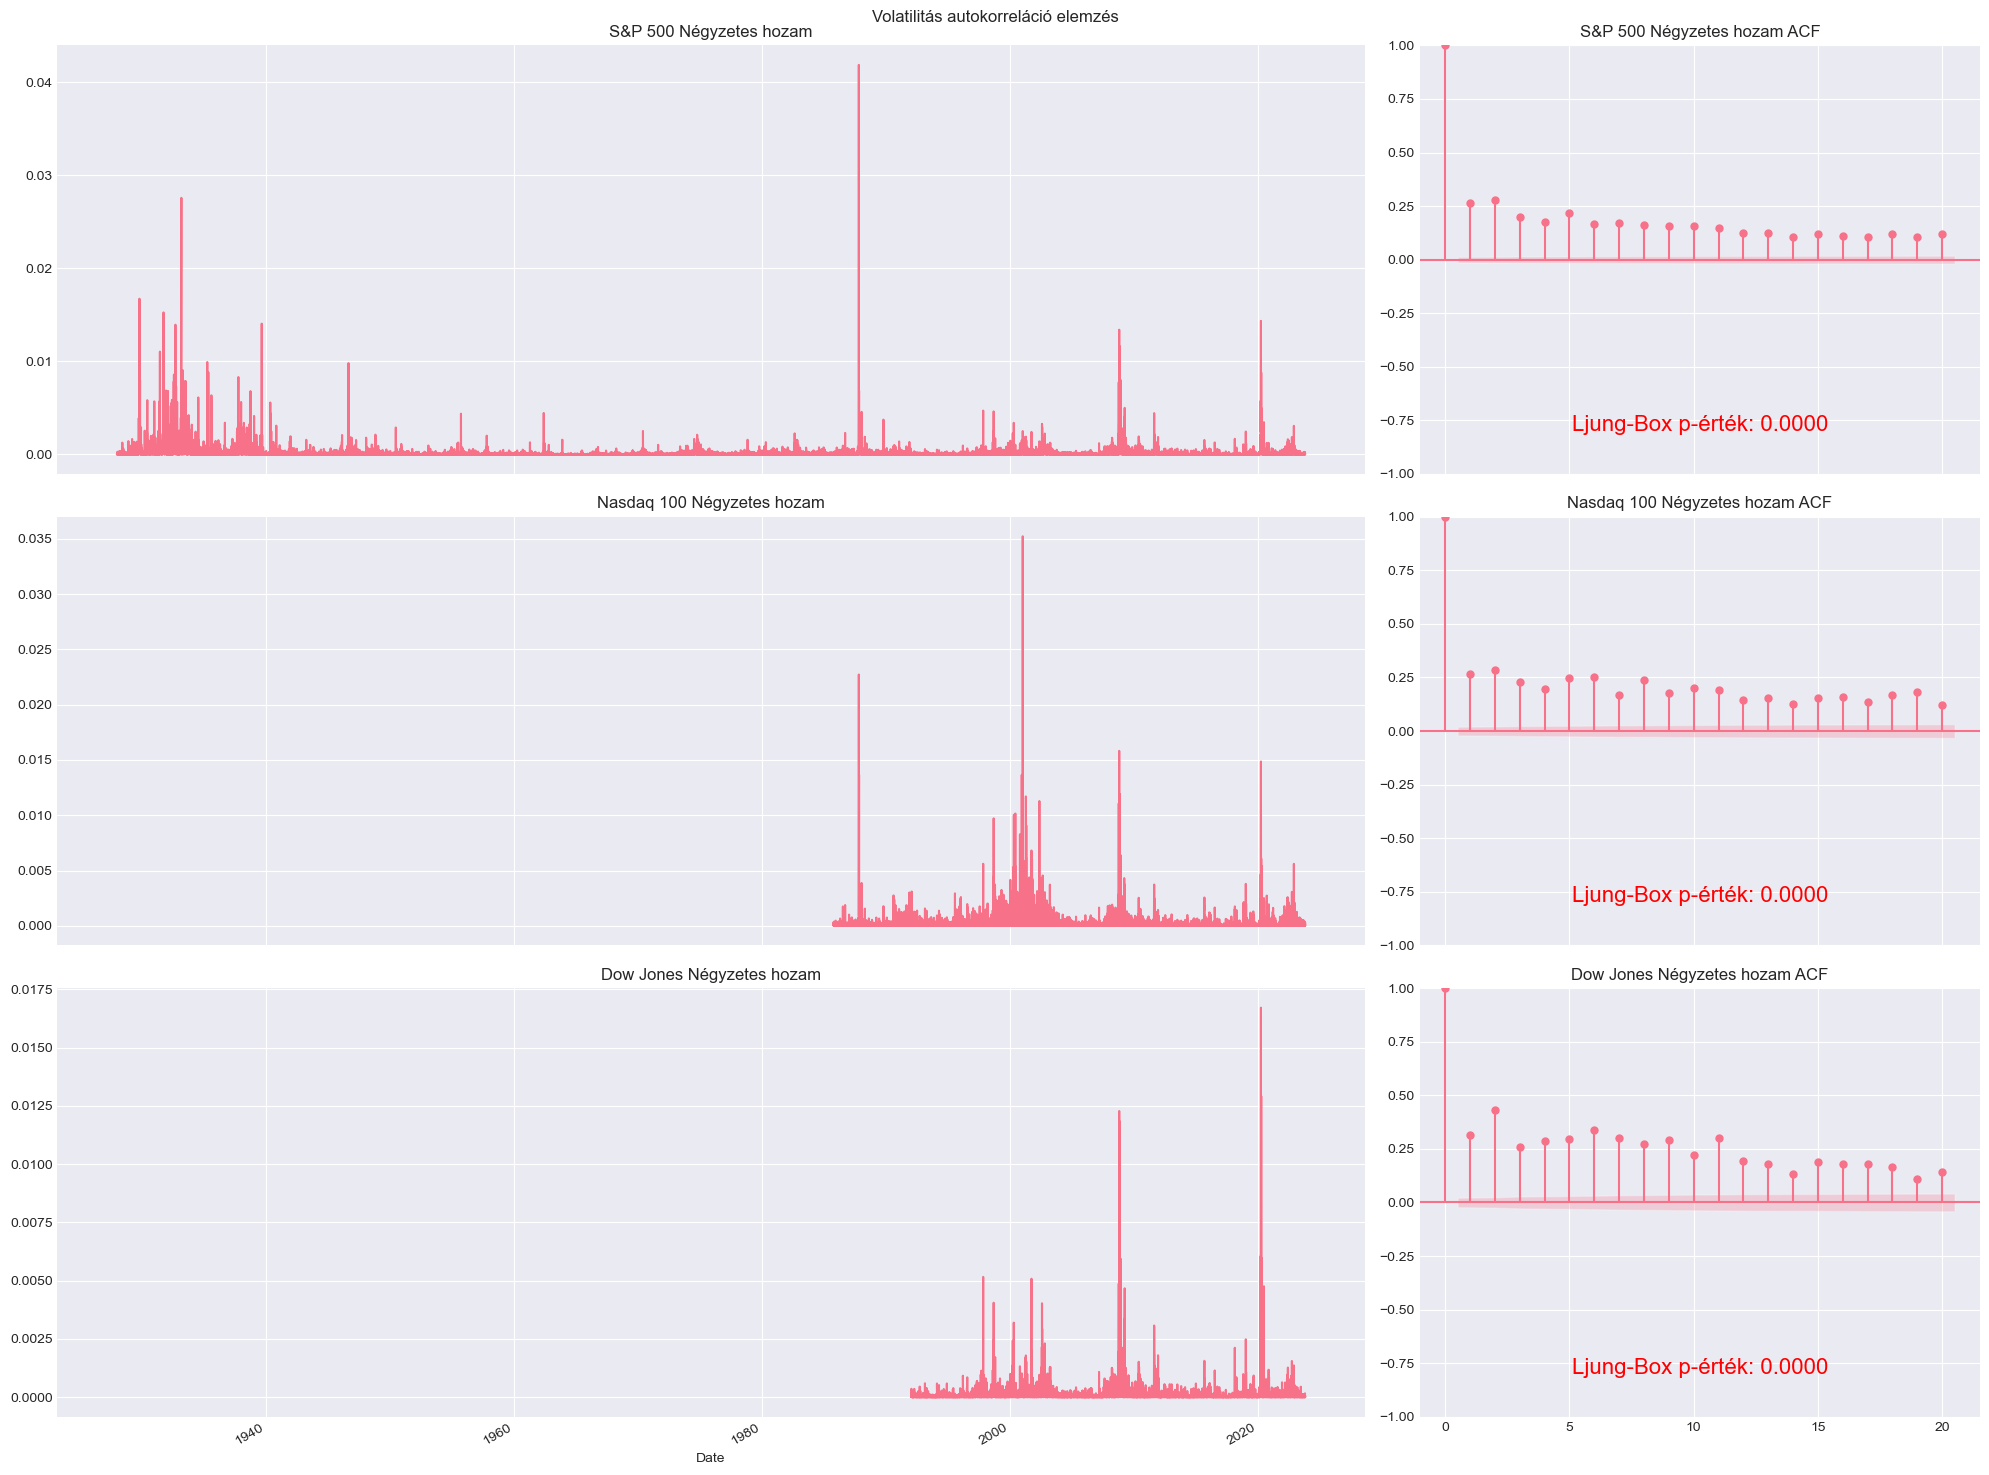

In [309]:
test_results = {}
acf_lag = 20
lags_to_test = 10

fig, axs = plt.subplots(len(indeces), 2, figsize=(20, 15), gridspec_kw={'width_ratios': [7, 3]}, sharex='col')
fig.suptitle("Volatilitás autokorreláció elemzés")

for i, (name, idx) in enumerate(indeces.items()):
    idx["Squared return"]=idx['Return']**2     # volatilitásként a négyzetes hozam használata

    # Ábrák létrehozása: bal oldalon az idősor, jobb oldalon az ACF
    idx["Squared return"].dropna().plot(ax=axs[i,0])
    axs[i,0].set_title(f"{name} Négyzetes hozam")
    plot_acf(idx["Squared return"].dropna(), lags=acf_lag, ax=axs[i,1])

    # Ljung-Box teszt lefuttatása a megadott késleltetésig
    lb_test = acorr_ljungbox(idx["Squared return"].dropna(), lags=lags_to_test, return_df=True)
    p_value = lb_test['lb_pvalue'].iloc[0]

    # p-érték megjelenítése a grafikonon
    axs[i,1].text(0.5, 0.1, f"Ljung-Box p-érték: {p_value:.4f}", transform=axs[i,1].transAxes, ha="center", color="red", fontsize=16)
    axs[i,1].set_title(f"{name} Négyzetes hozam ACF")

plt.tight_layout()
plt.show()


Már a négyzetes hozam grafikonján is megfigyelhetőek hullámok kiugró értékek körül, tehát nem túl meglepő, amikor az ACF-en is láthatóak jelentős értékek, még huszas lag mellett is.

Ezt a jelenséget szaknyelven **volatility clustering**-nek is szokták hívni.

A jobb oldali ACF grafikon és a számított p-érték itt várhatóan még drasztikusabb eltérést mutat a fehér zajtól, mint a hozamok esetén.

p-érték < 0.05: A nullhipotézist itt is elutasítjuk. Kijelenthető, hogy a volatilitás folyamata erősen autokorrelált.

## Az inflációs környezet hatása szektoronként

Amikor inflációról beszélünk, gyakran hajlamosak vagyunk egyetlen, mindent elsöprő mutatóként tekinteni rá, amely egységesen befolyásolja a gazdaságot. Azonban a piaci folyamatokat közelebbről vizsgálva hamar világossá válik, hogy az infláció változása nem egyformán érinti a szereplőket. Személyes kiváncsiságom folyamán többször is belefutottam bizonyos útmutatókba, melyek magas inflációs környezetben hivatottak befektetési tanácsokat adni. Ez által motiválva meg fogom vizsgálni, hogy milyen különbségek lépnek fel bizonyos szektorok közt különböző inflációs környezetben.


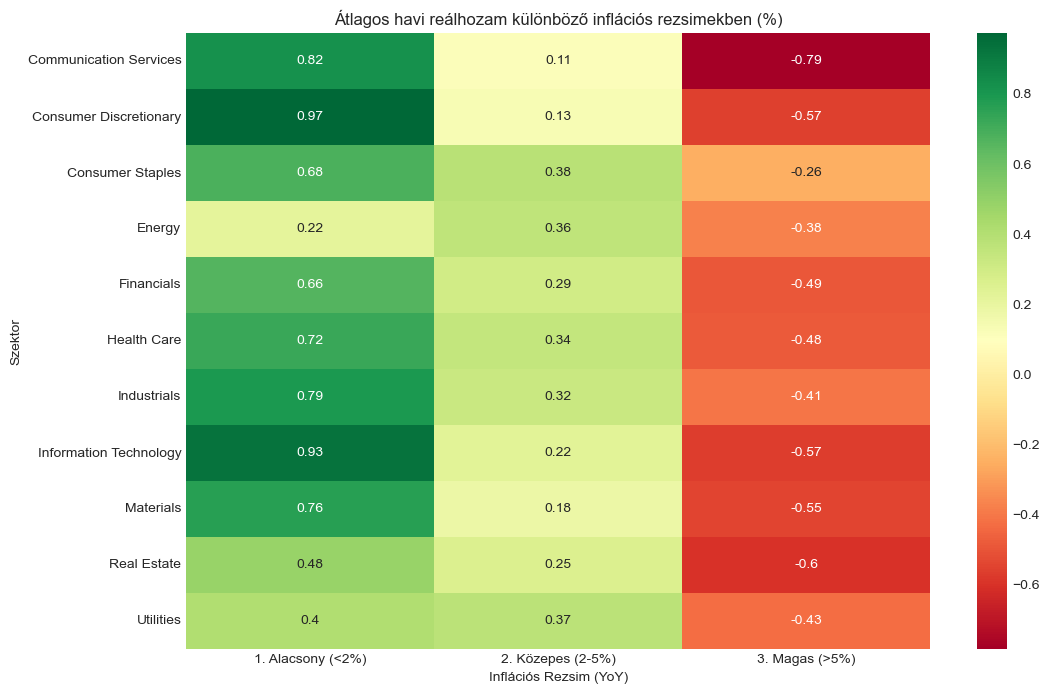

In [310]:
sector_map = pd.concat([
    sp500_companies[['Symbol', 'Sector']],
    dowjones_companies[['Symbol', 'Sector']],
    nasdaq100_companies[['Symbol', 'Sector']]
]).drop_duplicates(subset=['Symbol']).set_index('Symbol')['Sector']

monthly_returns = returns_stocks.resample('ME').sum()                               ## sum, mert log-hozamokat vizsgálunk, és azok időben additívak
sector_perf = monthly_returns.T.groupby(sector_map).mean().T                        # Szektor szintű átlagos teljesítmény kiszámítása

# Inflációs adatok előkészítése: MoM és YoY ráták kiszámítása
inflation["Inflation MoM"] = (1 + (inflation["Inflation"] / 100))**(1/12) - 1
inflation["Inflation YoY"] = inflation["Inflation"] / 100
inflation.index = pd.to_datetime(inflation.index) + pd.offsets.MonthEnd(0)

combined_df = sector_perf.join(inflation[["Inflation YoY", "Inflation MoM"]], how='inner')          # Szektoradatok és infláció összekapcsolása


# Rezsimek meghatározása a YoY infláció alapján
def get_inflation_regime(rate):
    if rate <= 0.02:
        return '1. Alacsony (<2%)'
    elif rate <= 0.05:
        return '2. Közepes (2-5%)'
    else:
        return '3. Magas (>5%)'

combined_df['Regime'] = combined_df['Inflation YoY'].apply(get_inflation_regime)

# Reálhozamok kiszámítása: Nominális log-hozam - log(1 + MoM infláció)
for sector in sector_perf.columns:
    combined_df[f'{sector}_Real'] = (
        combined_df[sector] - np.log(1 + combined_df['Inflation MoM'])
    )

# Átlagolás rezsimek szerint és oszlopnevek tisztítása
real_cols = [c for c in combined_df.columns if '_Real' in c]
regime_analysis = combined_df.groupby('Regime')[real_cols].mean()
# levágjuk a '_Real' utótagot
regime_analysis.columns = [c.replace('_Real', '') for c in regime_analysis.columns]

# Visszakonvertálás logaritmusból tényleges százalékos hozamra
regime_analysis_percent = np.exp(regime_analysis) - 1

# Heatmap vizualizáció százalékos formátumban
plt.figure(figsize=(12, 8))
sns.heatmap(regime_analysis_percent.T * 100, annot=True, cmap='RdYlGn')

plt.title('Átlagos havi reálhozam különböző inflációs rezsimekben (%)')
plt.xlabel('Inflációs Rezsim (YoY)')
plt.ylabel('Szektor')
plt.show()

A hőtérkép világosan mutatja, hogy az infláció mértéke alapjaiban határozza meg a befektetések vásárlóerejét:

 - Alacsony infláció (<2%): Ebben a környezetben minden szektor pozitív reálhozamot biztosított. Különösen a Consumer Discretionary (0,97%) és az Information Technology (0,93%) profitált az alacsony inflációs környezetből. Ebben a környezetben a növekedési fókuszú vállalatok profitálnak a leginkább az alacsony diszkontrátákból. Az Energy szektor reálhozama itt a legalacsonyabb, ami érthető, mivel az alacsony infláció gyakran alacsonyabb energiaárakkal párosul.
 - Közepes infláció (2-5%): Ebben a tartományban a piaci dinamika megváltozik, a növekedési szektorok lassulnak, míg a defenzív és ciklikus ágazatok relatív ereje megnő. Míg a technológiai, és nyersanyag szektor hozama jelentősen lassul, a defenzív szektorok, mint a Consumer Staples és a Utilities, megőrizték stabilitásukat, mivel ezek a szektorok képesek a leginkább áthárítani a  költségnövekedést a fogyasztókra. Ez többek közt magyarázható azzal, hogy bármilyen gazdasági helyzetben van, áram, víz, étel és hasonló dolgokra mindig szüksége lesz az embereknek.
 - Magas infláció (>5%): Ebben a rezsimben nincs olyan szektor, amely átlagosan pozitív reálhozamot tudna felmutatni. Ez a legkritikusabb szakasz, ahol minden szektor átlagos havi reálhozama negatívba fordult. A legnagyobb reálérték-vesztést a Communication Services (-0,79%) és a Real Estate (-0,60%) szenvedte el, az utóbbi esetben az ilyen környezetre jellemző magas kamatok a legfőbb befolyásoló tényező. Bár a hozamuk negatív, a Consumer Staples és az Energy a "legkisebb rossznak". Ezek a szektorok nyújtják a legjobb védelmet a vásárlóerő radikális romlása ellen, a korábban is releváns okok miatt.

A korábban általam gyakran hallott tanácsokat végre adatokkal alátámasztva is sikerúlt igazolnom. Míg 2% alatt a kockázatos eszközök dominálnak, 5% felett a teljes részvénypiac reálérték-vesztést szenved el, és csak a defenzív/reáleszköz alapú szektorok képesek mérsékelni a veszteségeket. Mellesleg, ilyen esetben a legkevésbé kockázatos, és a grafikon alapján is legkifizetődőbb dolog kötvényeket vásárolni, melyek néhány esetben az infláció mértékével is számolnak.


## After hours - Normal hours hozam vizsgálata

A modern részvénypiacok egyik legérdekesebb kettőssége a kereskedési időszakok szerkezetéből adódik. Miközben a grafikonokon gyakran egy folytonos vonalat látunk, a valóságban két élesen elkülöníthető szakasz váltja egymást: a napközbeni kereskedés (Intraday / Normal hours) és a zárástól nyitásig tartó időszak (Overnight / After hours). Ez a vizsgálat azt hivatott feltárni, hogy létezik-e szisztematikus eltérés a két periódus teljesítménye között.

 - Információs aszimmetria: A fontos vállalati jelentések, makrogazdasági adatok és váratlan politikai események gyakran a tőzsdezárás után látnak napvilágot. Ezek hatása a másnapi nyitóárban („gap”) árazódik be.
 - Likviditás és volatilitás: A hivatalos nyitvatartás alatt a nagy intézményi befektetők aktivitása és a magas likviditás dominál, míg az éjszakai szakaszban az alacsonyabb forgalom miatt a piac érzékenyebb lehet a sokkokra.
 - Anomáliák keresése: Számos kutatás (például az amerikai indexek esetén) arra mutatott rá, hogy a hosszú távú emelkedő trend jelentős része az éjszakai órákban realizálódik, míg a napközbeni szakasz gyakran oldalazást vagy korrekciót mutat.

A vizsgálat módszertana: A számítás során az alábbi két komponenst hasonlítjuk össze naponta:
 - Overnight hozam: A mai nyitóár és az előző napi záróár különbsége.
 - Intraday hozam: A mai záróár és a mai nyitóár különbsége.

A célunk annak meghatározása, hogy a választott indexeknél a napközbeni és az éjszakai hozam különbsége milyen eloszlást mutat az elmúlt 40 év távlatában.


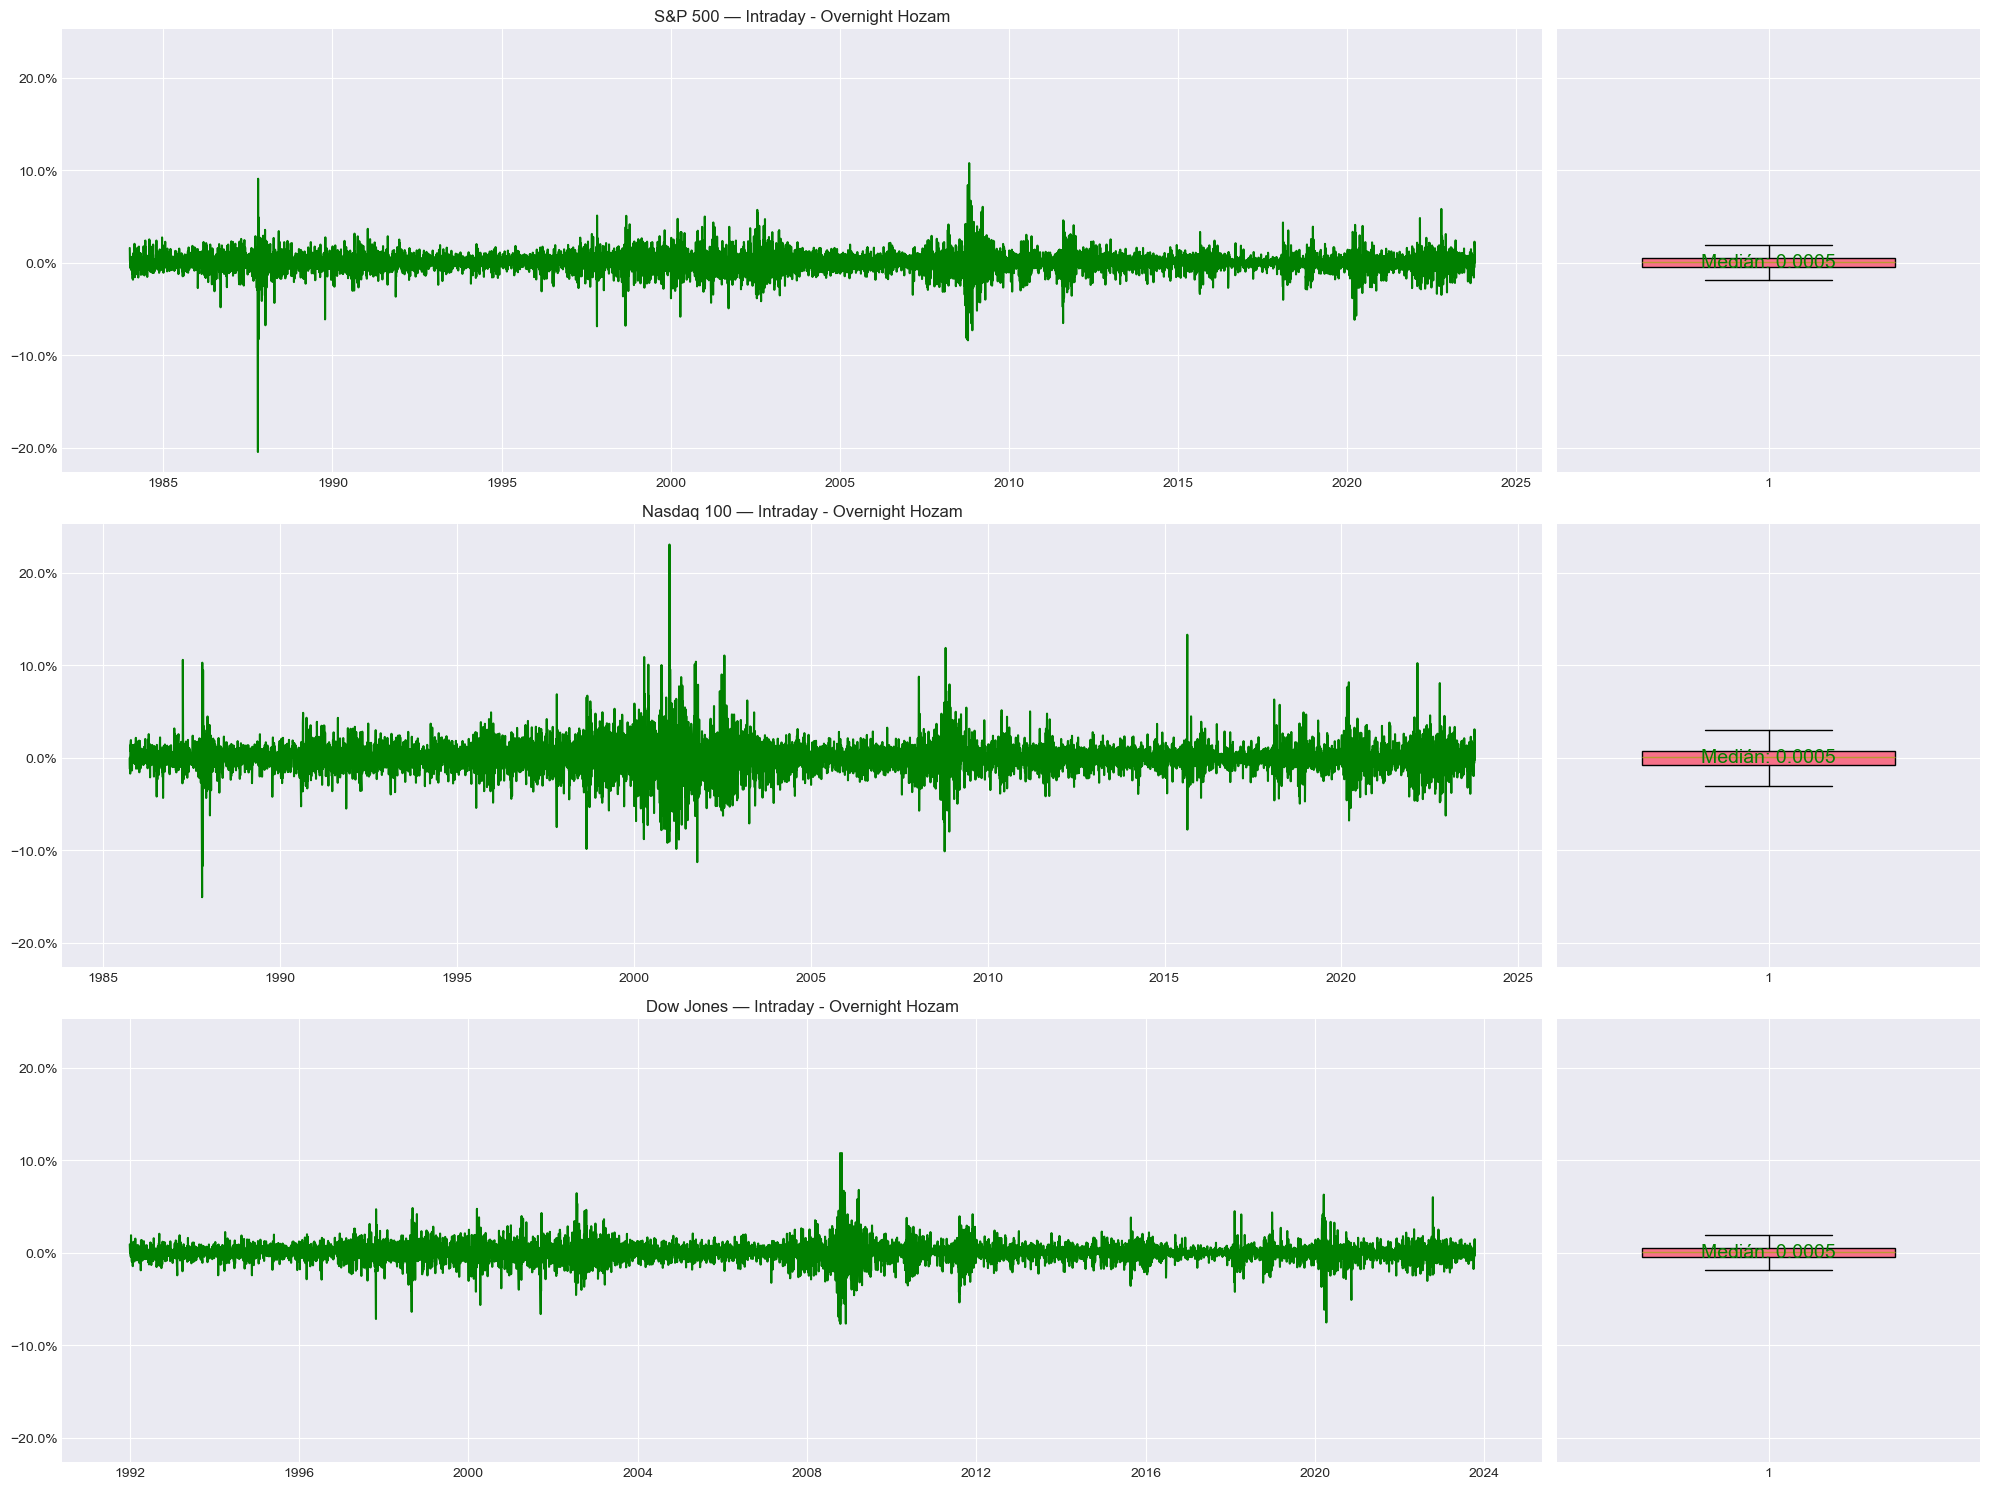

In [311]:
lookback_years = 40

return_diff = {}

for name, idx in indeces.items():
    df = idx.copy()

    # lookback_years-re korlátoz
    all_years = df.index.year.unique()
    last_years = all_years[-lookback_years:] if len(all_years) >= lookback_years else all_years
    df = df[df.index.year.isin(last_years)]

    df['PrevClose'] = df['Close'].shift(1)

    # Hibás adatok (0-ás nyitóár) javítása az előző záróárral
    df['Open_fixed'] = df['Open']
    mask_zero = df['Open_fixed'] == 0
    df.loc[mask_zero, 'Open_fixed'] = df.loc[mask_zero, 'PrevClose']

    # Hiányzó adatok eltávolítása a pontos számítás érdekében
    df = df.dropna(subset=['Open_fixed', 'PrevClose', 'Close'])
    df = df[df['Open_fixed'] != 0]

    df['OvernightReturn'] = (df['Open_fixed'] - df['PrevClose']) / df['PrevClose']      # Éjszakai hozam: (Nyitó - Előző Záró) / Előző Záró
    df['IntradayReturn'] = (df['Close'] - df['Open_fixed']) / df['Open_fixed']          # Napközbeni hozam: (Záró - Nyitó) / Nyitó

    return_diff[name] =  df['IntradayReturn'] - df['OvernightReturn']                   # A két szakasz hozamkülönbségének meghatározása

#Grafikon
fig, axs = plt.subplots(len(indeces), 2, figsize=(20,15), sharex=False, sharey=True, gridspec_kw={'width_ratios': [7, 2]})

for i, name in enumerate(indeces.keys()):
    ax_line = axs[i,0] if len(indeces) > 1 else axs[0]

    # A különbségek időbeli alakulása
    ax_line.plot(return_diff[name].index, return_diff[name], color='green')
    ax_line.set_title(f"{name} — Intraday - Overnight Hozam")
    ax_line.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    # A medián érték kiírása a grafikonra
    axs[i,1].boxplot(return_diff[name].values, patch_artist=True, widths=0.6, showfliers=False)
    median_val = return_diff[name].median()
    axs[i,1].text(1, median_val, f"Medián: {median_val:.4f}", color='green', va='center', ha='center', fontsize=14)

plt.tight_layout()
plt.show()

A pozitív előjelű medián (0,05%) azt jelenti, hogy a vizsgált 40 év során egy tipikus kereskedési napon a napközbeni szakasz 0,05%-kal teljesítette felül az éjszakait. Ez nem azt jelenti, hogy az éjszakák rosszak, hanem azt, hogy a napközbeni mozgásban statisztikailag több felfelé mutató erő maradt, mint amennyit az éjszakai nyitó gap elvitt. Az eredmény azt mutatja, hogy az S&P 500 és hasonló indexeknél a Intraday dominanciája egy hajszállal erősebb.

Bár a szám kicsi, statisztikai értelemben ez egy stabil torzítás. Ha a piac tökéletesen hatékony lenne, és a hírek beárazódása egyenletesen oszlana el, akkor a különbség mediánjának 0-nak kellene lennie. A 0,0005-ös érték azt jelzi, hogy van egy szisztematikus aszimmetria. A piac valamiért „szívesebben” emelkedik akkor, amikor a kereskedők aktívan jelen vannak, mint a zárva tartás alatt.

## Év hónapjainak átlagos hozama, volatilitása

A témával való ismerkedésem és beszélgetések folyamán gyakran hallottam, hogy a nyár végi - őszi hónapok a legrosszabbak részvények teljesítményére tekintettel.
Ebben a felyezetben ezt a feltevést fogom megvizsgálni, és kutatással okot találni az eredményre

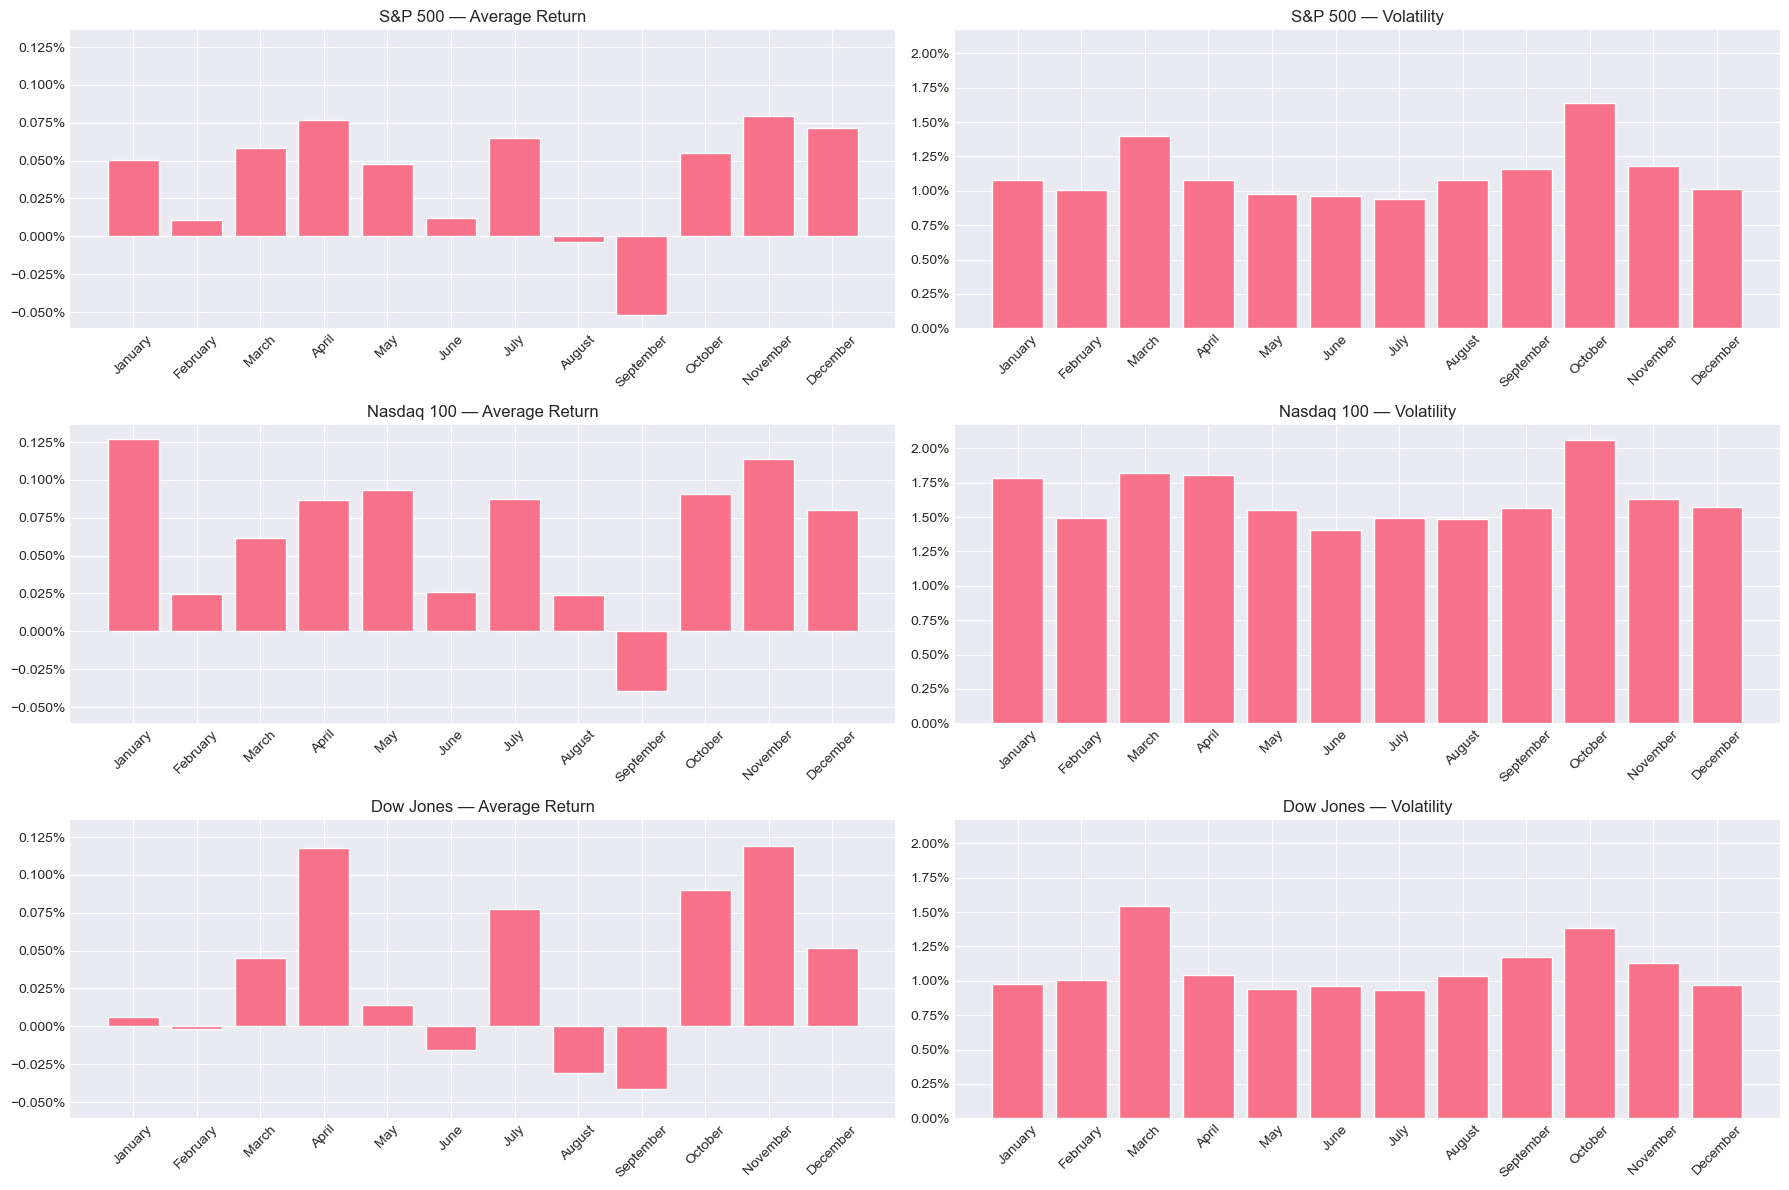

In [312]:
x = 40

month_avg = {}
month_vol = {}
month_volume = {}

for name, idx in indeces.items():
    # Évek meghatározása
    all_years = idx.index.year.unique()
    last_years = all_years[-x:] if len(all_years) >= x else all_years

    # Adatszűrés az utolsó 40 évre
    idx_recent = idx[idx.index.year.isin(last_years)].copy()
    idx_recent['Month'] = idx_recent.index.month

    # Havi szintű csoportosítás, átlag és szórás számítása
    average = idx_recent.groupby('Month')['Return'].mean()
    volatility = idx_recent.groupby('Month')['Return'].std()

    # A numerikus hónapok átírása olvasható nevekre
    average.index = average.index.map(lambda m: calendar.month_name[m])
    volatility.index = volatility.index.map(lambda m: calendar.month_name[m])

    month_avg[name] = average
    month_vol[name] = volatility

index_names = list(month_avg.keys())
months = month_avg[index_names[0]].index

# Grafikonok
fig, axs = plt.subplots(3, 2, figsize=(18, 12), sharey='col')

metrics = [
    ("Average Return", month_avg),
    ("Volatility", month_vol)
]

for i, idx_name in enumerate(index_names):
    for j, (metric_name, metric_dict) in enumerate(metrics):
        ax = axs[i, j]
        values = metric_dict[idx_name].values
        # Oszlopdiagram a havi értékekkel
        ax.bar(months, values)
        ax.set_title(f"{idx_name} — {metric_name}")
        ax.set_xticks(range(len(months)))
        ax.set_xticklabels(months, rotation=45)
        ax.grid(True, axis='y')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.tight_layout()
plt.show()



Látható, hogy a vizsgált adatok alapján tényleg az augusztus-szeptember időszak a leggyengébb.

A hozamok láthatóan erősek januárban, év végi adóoptimalizálás miatt, új pénz beáramlása miatt, és alapok viselkedése miatt. Ezután lecsillapodik a következő hónapokban. Április szintén az erősebb hónapokhoz tartozik Q1-es jelentések, USA-ban adóhónap miatt is. Nyár általában gyengébb illikviditás, makro narratívák hiánya, és általános "üresjárat miatt". Szeptember a legrosszabb hónap alapok viselkedése, makro kockázatok miatt. Ezután erősebb időszak következik, részben a korábbi gyenge hónapok miatti 'leárazott' részvényeket vásárló piaci résztvevők miatt.

Összesítve ez a ciklikusság adóoptimalizálás, negyedéves adatok, likviditási időszakok, intézményi viselkedési minták, és makrogazdasági ciklusok kombinációjával magyarázható.

A volatilitás tavasszal és ősszel magasabb, ami a makroadatok, és korábbi gyenge piac kihasználásával magyarázható

## Korreláció szerinti csoportosítással részvények szektorokra bontása

Alapvetően ez volt az első dolog ami eszembe jutott a házifeladat kiválastásánál, így a végére hagytam, és kicsit mélyebben megvizsgálom a szekorok közötti, és szektorokon belüli összefüggéseket, és megpróbálom megmagyarázni őket.

A részvények korábbi korrelációs vizsgálatánál megfigyeltem, hogy az általam ismert, nagyjából egy csoportba tartozó részvények hajlamosak magas korrelációt mutatni egymással, míg alacsony korreláció jellemzi az egymástól távol álló részvényeket. Ebben a részben ezeket tovább vizsgálom, és megpróbálom ezen korrelációs adatok alapján visszafejteni azt, hogy mely részvények tartoznak ugyanabba a szektorba.


A végső csoportosítás előtt megvizsgálom a szektorokon belüli, és a szektorok közötti korreláció mértékét, és megpróbálom azonosítani, mely részeket fog valószínűleg könnyen kezelni, és mely szektoroknál léphet fel probléma az eredményben.

### Elméleti háttér

Alapvető összefüggések miatt már sejthetjük, hogy ez az állítás valószínűleg pozitív eredményre vezet, mert

 - Közösek a  fundamentumok: Az azonos szektorban lévő cégek hasonló makrogazdasági hatásoknak vannak kitéve (pl. kamatkörnyezet, nyersanyagárak, szabályozási környezet)
 - Szektor-rotáció: A befektetők gyakran szektorszinten döntenek, hogy mibe fektetnek (pl. eladják a tech-szektor beli részvényeiket és veszik az energiaszektor bizonyos részvényeit), ami felerősíti a szektoron belüli korrelációt

A végső cél tulajdonképpen a valós, statikus, üzleti tevékenységeken alapuló besorolás és a részvényárfolyam által meghatározott "hovatartozás" összehasonlítása.

### Legerősebb korrelációk

Először megjelenítem a legjobban korreláló részvényeket, és megvizsgálom, hogy a feltevésem alapján valóban gyakori-e, hogy a magas korrelációjú részvénypárok azonos szektorokban találhatóak.

n paraméterrel állítható, hogy mennyit szeretnénk megjeleníteni.

In [313]:
# A vizsgált párok száma
n = 1000

# mátrix kiterítése listává, oszlopok elnevezése
corr_df = corr_matrix.stack().reset_index()
corr_df.columns = ['A', 'B', 'Correlation']

# Szűrés: az önkorrelációk elhagyása, redundancia elkerülése
corr_df = corr_df[
    (corr_df['A'] != corr_df['B']) &
    (corr_df['A'] < corr_df['B'])
].sort_values(by='Correlation', ascending=False)

# Az első n darab legszorosabb kapcsolat kiválasztása
top_n = corr_df.head(n).copy()

# szektorinformációk hozzárendelése mindkét részvényhez a sector_map segítségével
top_n['A Sector'] = top_n['A'].map(sector_map)
top_n['B Sector'] = top_n['B'].map(sector_map)

# megszámolom, hány párnál egyezik meg a két részvény szektora
matching_count = (top_n['A Sector'] == top_n['B Sector']).sum()

print(f"A {n} legjobban korreláló részvényből {matching_count} db azonos szektorból származik.")


A 1000 legjobban korreláló részvényből 824 db azonos szektorból származik.


Amint az eredményen látható, erős bizonyítékunk van arra, hogy a korreláció jól jellemzi azt, hogy melyik cégek találhatóak azonos szektorokban.
Emmellett érdemes kontextusba helyezni, hogy mit is jelent ez az érték. Ha véletlen szerűen választanánk két részvényt, annak az esélye, hogy azok ugyan abban a szektorban találhatóak, ~11%. Ez igazolja, hogy a korreláció nem véletlen zaj, hanem a szektor-specifikus kockázati tényezők (pl. olajár az energiaiparnál, kamatlábak a bankoknál) hatását tükrözi a részvények árazásában.

A maradék 17,6% is fontos. Léteznek olyan iparágak, amelyek bár különböző szektorban vannak, szorosan együtt mozognak. Gyakran emlegetik az emberek a big-tech-et, olyan kontextusban, mintha ez egy szektor lenne, ami olyan szinten érthető, hogy ezek a cégek gyakran hajlamosak hasonló irányba mozogni. Az alapvető probléma az, hogy ezek a cégek már annyi különböző piacon működnek, hogy nehéz elválasztani őket. Például az Amazon és Google is "Big-Tech", fe az egyik Consumer Discretionary, a másik pedig Communication technologies. Egy másik példa pedig a Financials és Real Estate, mert mindkettőnek óriási befolyásoló tényező az aktuális kamatkörnyezet.



### Átlagos korreláció szektorokon belül

Ebben a fejezetben megvizsgálom, hogy egy szektoron belül található részvények milyen átlagos korrelációt mutatnak egymással. Ez hasznos lesz később arra, hogy megértsem miért, tévedhetett a klaszterező algoritmus bizonyos szektorok közt.


Ez a vizsgálat alapozza meg a klaszterezés várható pontosságát. A Ward-módszer logikája szerint a távolságmátrixban lévő sűrűsödéseket keressük.
Tehát ahol az átlagos korreláció magas, ott a pontok a többdimenziós térben közel helyezkednek el egymáshoz, így ott magas Purity értékre számítok. Ezzel szemben az alacsony belső korrelációjú  szektorok azt jelzik, hogy az algoritmus szét fogja szórni a cégeket, mivel a belső távolságok nagyobbak lehetnek, mint bizonyos szektorokon átívelő kapcsolatok.

Szekrorokon belüli átlagos korreláció átlaga: 0.40


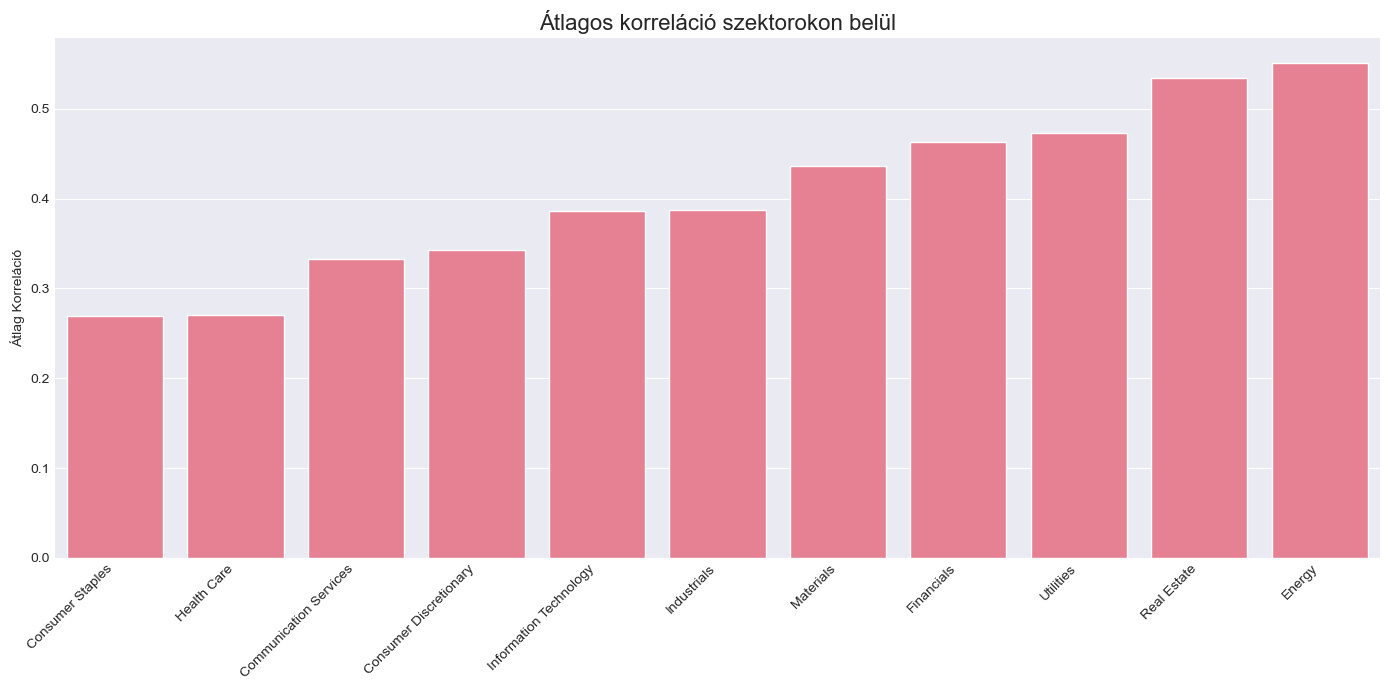

In [314]:
# Szimbólumok csoportosítása szektorok szerint listákba
sector_groups = sector_map.reset_index().groupby('Sector')['Symbol'].apply(list)

sector_correlation_results = {}

for sector_name, symbols in sector_groups.items():
    valid_symbols = [s for s in symbols if s in returns_stocks.columns]                     # Csak olyan szimbólumokat vizsgálunk, amelyek szerepelnek a hozam-adattáblában

    corr_matrix_forpair = returns_stocks[valid_symbols].corr()                                              # Adott szektor részvényeinek korrelációs mátrixa
    pairwise_correlations = corr_matrix_forpair.values[np.triu_indices_from(corr_matrix_forpair, k=1)]      # A mátrix felső háromszögéből kinyerjük az egyedi párok korrelációit
    sector_correlation_results[sector_name] = np.mean(pairwise_correlations)                                # A szektoron belüli párok átlagos korrelációjának eltárolása


avg_corr_series = pd.Series(sector_correlation_results).sort_values()                       # Sorrendbe állítás az átlagos korreláció értéke szerint
print(f"Szekrorokon belüli átlagos korreláció átlaga: {avg_corr_series.mean():.2f}")

#grafikon
plt.figure(figsize=(14, 7))
ax = sns.barplot(avg_corr_series)

plt.title('Átlagos korreláció szektorokon belül', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Átlag Korreláció')
plt.tight_layout()
plt.show()

**Értelmezés**
 - A közmű és az energia szektorok mutatják a legmagasabb belső korrelációt, ami arra utal, hogy ezeket a részvényeket elsősorban egységes makrogazdasági tényezők, például nyersanyagárak vagy kamatkörnyezet mozgatják.
 - A Health Care és a Communication Services szektor alacsony korrelációja abból adódik, hogy a bennük működő vállalatok eltérő üzleti modellekre, szabályozási környezetre és gazdasági ciklusokra reagálnak, ezért árfolyamaik kevésbé mozognak együtt. Ez a későbbiekben jelentheti azt, hogy a klaszterező algoritmus hajlamos lesz szétszórni ezeket a részvényeket több másik szektor között, ha a többi szektorral a korrelációja elég nagy.
 - Átlagos piaci klaszterek: Az olyan középső szektorok, mint az Information Technology vagy a Financials, a piaci átlaghoz közeli együttmozgást mutatnak, ami kiegyensúlyozott arányt jelez a szektorhírek és az egyedi vállalati teljesítmények között.

A hierarchikus klaszterezés egyik célja a csoporton belüli variancia minimalizálása. A magas átlagos korreláció gyakorlatilag alacsony varianciát jelent a szektoron belül. Ezért várhatjuk el, hogy az Energy vagy a Utilities szektorokat stabil, jól elkülöníthető "tömbökként" találja meg, míg a Health Care esetében a nagy belső szórás miatt a klaszterek széteshetnek.

### Szektorok közötti korreláció

A hierarchikus klaszterezés másik célja pedig a csoportok közti variancia maximalizálása, ami feltevésem szerint megegyezik a szektorok közötti korreláció mértékével.
Tehát végül a szektorok közti korrelációt vizsgálom, mielőtt a klaszterezésre térek, ezzel felismerhetőek mely szektorokat lesz könnyű elkülöníteni, és melyeket keverhet össze nagyobb valószínűséggel a klaszterező algoritmus.

Ha két szektor között alacsony a korreláció, az a többdimenziós térben nagy távolságot jelent. Itt a variancia eleve magas, így a klaszterező éles határvonalat tud húzni. Ezzel szemben a magas korrelációjú szektorok átfedést mutatnak, ami megmagyarázza, miért fog az algoritmus itt több hibát ejteni.

Ez az elemzés előrevetíti a kiértékelés eredményeit: a Recall értékek várhatóan a defenzív, alacsony korrelációjú szektoroknál lesznek a legmagasabbak. Ahol magasabb a korreláció, ott a 'Cluster Purity' valószínűleg alacsonyabb lesz, mivel a piaci mozgások elmossák a különbségeket.



Szektorok közti átlagkorreláció átlaga 0.59


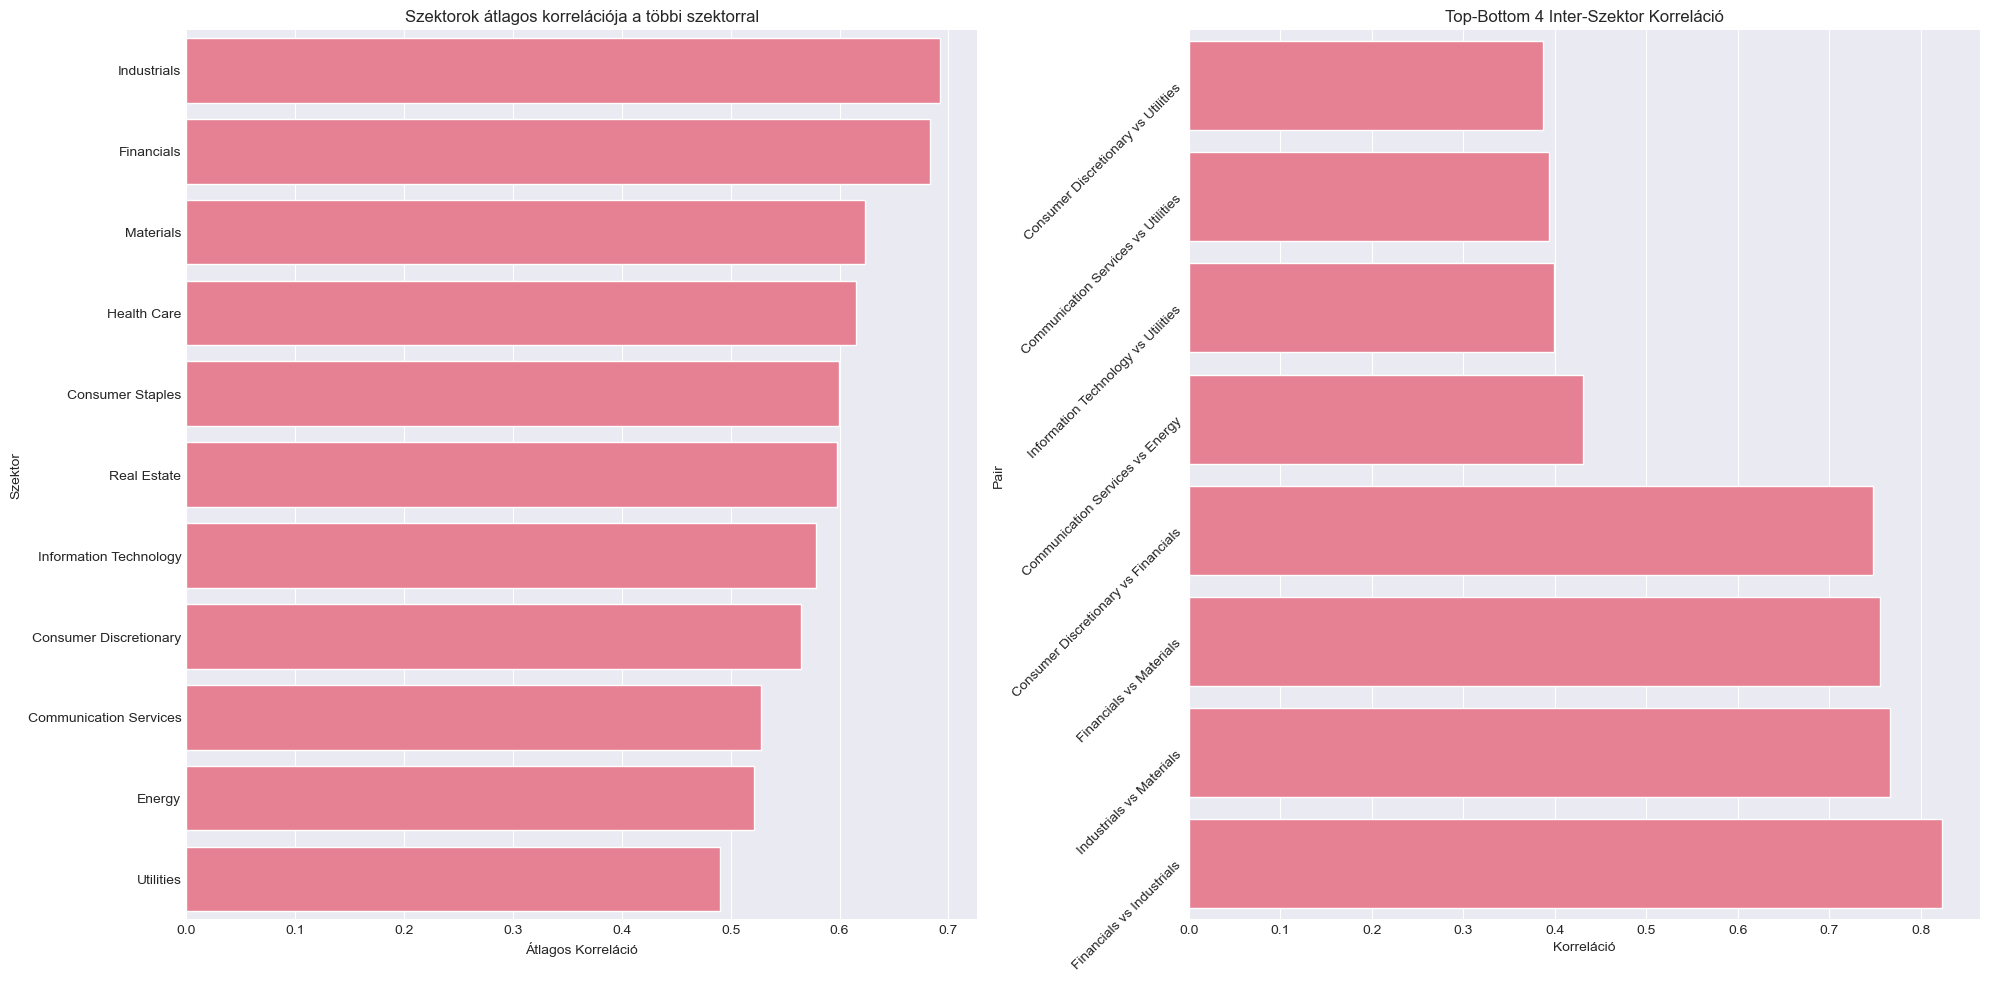

In [315]:
# A legszélsőségesebb párok száma
N = 4

returns_with_sectors = returns_stocks.T.merge(              # Részvények és szektorok összekapcsolása
    sector_map,
    left_index=True,
    right_on='Symbol',
    how='inner'
)
returns_with_sectors.index.name = 'Symbol'
returns_with_sectors.dropna(subset=['Sector'], inplace=True)

# Szektor-szintű napi átlaghozamok kiszámítása
sector_returns = returns_with_sectors.groupby('Sector').mean().T
sector_returns.index = pd.to_datetime(sector_returns.index)

# Szektorok közötti korrelációs mátrix előállítása
sector_corr_matrix = sector_returns.corr()
sector_corr_matrix.index.name = 'Sector_A'
sector_corr_matrix.columns.name = 'Sector_B'

# Szektor-párok kiterítése és szűrése a Top/Bottom párokhoz
corr_df_sector = sector_corr_matrix.stack().reset_index()
corr_df_sector.columns = ['Sector_A', 'Sector_B', 'Correlation']

corr_df_filtered = corr_df_sector[
    (corr_df_sector['Sector_A'] < corr_df_sector['Sector_B'])
].copy()

# A 4 legmagasabb és 4 legalacsonyabb korrelációjú szektor-pár kiválasztása
top_pos = corr_df_filtered.sort_values(by='Correlation', ascending=False).head(N)
top_neg = corr_df_filtered.sort_values(by='Correlation', ascending=True).head(N)
plot_data = pd.concat([top_pos, top_neg]).sort_values(by='Correlation', ascending=True)
plot_data['Pair'] = plot_data['Sector_A'] + ' vs ' + plot_data['Sector_B']

# Átlagos korreláció kiszámítása minden szektorra (önkorreláció nélkül)
avg_corr_per_sector = (sector_corr_matrix.sum() - 1) / (len(sector_corr_matrix) - 1)
avg_corr_per_sector = avg_corr_per_sector.sort_values(ascending=False).reset_index()
avg_corr_per_sector.columns = ['Sector', 'Avg_Correlation']

print(f"Szektorok közti átlagkorreláció átlaga {avg_corr_per_sector['Avg_Correlation'].mean():.2f}")

#grafikon
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.barplot(x='Avg_Correlation', y='Sector', data=avg_corr_per_sector, ax=axes[0])
axes[0].set_title("Szektorok átlagos korrelációja a többi szektorral")
axes[0].set_xlabel("Átlagos Korreláció")
axes[0].set_ylabel("Szektor")


ax = sns.barplot(x='Correlation', y='Pair', data=plot_data, ax=axes[1])
axes[1].set_title(f"Top-Bottom {N} Inter-Szektor Korreláció")
axes[1].tick_params(axis='y', rotation=45)
axes[1].set_xlabel("Korreláció")

plt.tight_layout()
plt.show()

**Szektorok átlagos szektorok közti korrelációja**
 - Magas átlagú szektorok (Industrials, Financials): Ezeket a szektorokat nevezhetjük a piac 'központi szektorainak'. Mivel átlagosan mindenki mással is magasabb korrelációt mutatnak, a hierarchikus klaszterezés során ezek lesznek a vonzási pontok, amelyek hajlamosak magukba szívni más szektorokból érkező részvényeket is. Itt várható a legtöbb tévesztés.
 - Alacsony átlagú szektorok (Energy, Utilities): Ezek a szektorok diverzifikációs lehetőségek. Alacsony átlagos korrelációjuk a többiekkel azt jelenti, hogy a többdimenziós térben messze esnek a piac centrumától. Emiatt az algoritmus itt fogja a legmagasabb Recall és Purity értékű klasztereket alkotni.

**Szektor-Szektor összehasonlítás**
 - Magas Pozitív Korreláció: Ezek a párok (pl. Financials vs. Industrials, Industrials vs. Materials) jóval átlag feletti korrelációval rendelkeznek.
    - Pénzügyi Ok: Ezek a szektorok ciklikusak vagy növekedési fázisban lévők, és szoros függőségben állnak az általános gazdasági hangulattal.
    - Mozgás: Ha a gazdasági növekedés erős, a fogyasztás nő, a befektetések megindulnak, ekkor ezek a szektorok egyszerre emelkednek, ellenkező esetben szintén hasonlóan esnek.
    - A klaszterezésnél ezen magas korrelációjú szektorok részvényeit nagyobb eséllyel tévesztheti egymás között.

 - Alacsony Korreláció: Ezek a párok (pl. Information Technology vs. Utilities, Communication Services vs. Energy) a skála alján helyezkednek el, jóval átlag alatt.
    - Pénzügyi Ok: Ezek a párok eltérő gazdasági faktorokra reagálnak, néha ellentétes irányba is mozognak.
    - A közművek és az alapvető fogyasztási cikkek defenzív szektorok. Ezek a cégek stabil cash flow-val rendelkeznek, és az emberek recesszió alatt is veszik a termékeiket. Amikor a piac egésze esik, a defenzív szektorok jobban tartják magukat.
    - Kamatérzékenység: A Utilities szektor árfolyama érzékeny a kamatlábakra, míg a Growth szektorok inkább a jövőbeli kilátásokra.
    - A klaszterezésnél ezen szektorok közti tévesztés valószínűsége alacsony lesz.

A fenti vizsgálatok igazolják a klaszterezés jogosultságát: ha minden szektor korrelációja például 0.8 felett lenne, a klaszterezés értelmetlen lenne, ha pedig például 0.3 alatt, akkor triviális. Az ezek közötti skála az, ahol a gépi tanulási algoritmusok valódi hozzáadott értéket adnak a rejtett struktúrák feltárásával.

### Hierarchikus klaszterezés

Végül jöjjön a klaszterezés és annak kiértékelése

 - Távolságmátrix létrehozása: A korreláció önmagában nem távolság, ezért a kód átalakítja azt:  korrelációt (1 - corr) formára hozza, majd gyököt von belőle. Ezáltal ha két részvény korrelációja 1, a távolságuk 0 lesz.
 - A squareform függvény egy tömörített formátumot készít, amit az algoritmus hatékonyabban kezel. Ezt eleinte kihagytam, de miközben optimalizálási eszközöket kerestem tatláltam rá, egy LLM segítségével
 - Ward-távolság használata, mely úgy csoportosít, hogy a csoporton belüli szórásnégyzet növekedése minimális legyen
 - Dendogram elvágása, hogy 11 klaszter jöjjön létre, melyeket később megfeleltetek egyes szektoroknak


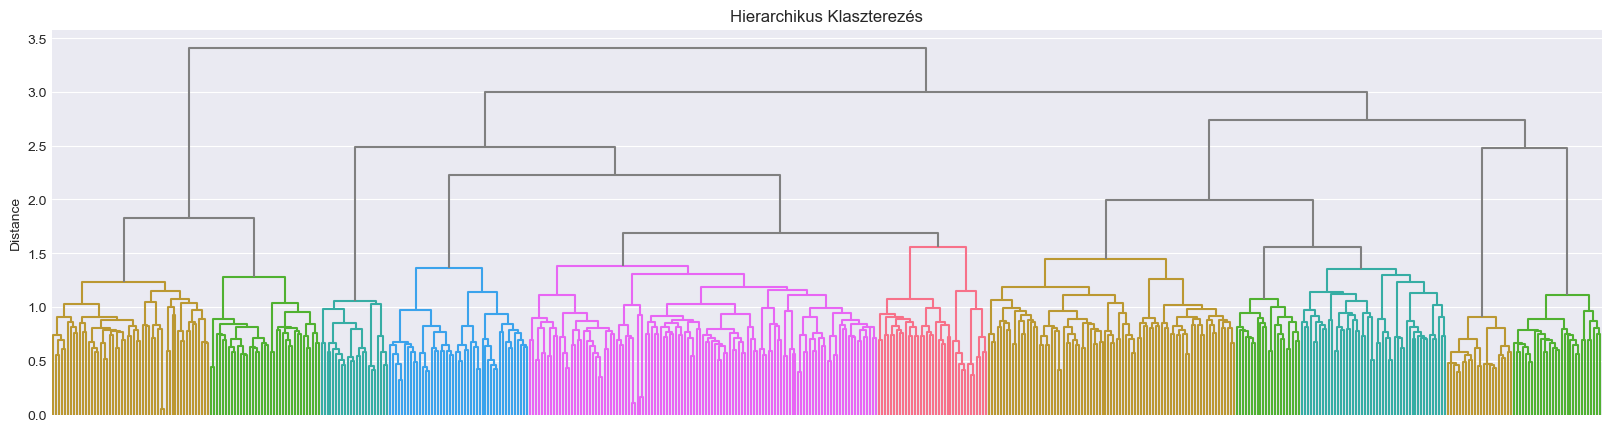

In [316]:
num_clusters = 11 ##Ennyi szektor van

dist = np.sqrt(1 - corr_matrix)                     # Korreláció átalakítása euklideszi jellegű távolsággá
dist_condensed = squareform(dist, checks=False)     # Kondenzált távolságmátrix létrehozása a linkage függvény számára

linkage_result = linkage(dist_condensed, method="ward")     # klaszterezés ward módszerrel
threshold = linkage_result[-num_clusters + 1, 2]            # Küszöbérték a színezéshez

# Dendogram megjelenítése
plt.figure(figsize=(20, 5))
dendrogram(linkage_result, orientation='top', labels=corr_matrix.columns.tolist(), color_threshold=threshold, above_threshold_color='grey')
plt.xticks([])
plt.title("Hierarchikus Klaszterezés")
plt.ylabel("Distance")
plt.show()

clusters = fcluster(linkage_result, num_clusters, criterion='maxclust')         # Részvények hozzárendelése a konkrét klaszterekhez

#Eredmények rögzítése későbbi validációhoz
cluster_df = pd.DataFrame({
    'Symbol': returns_stocks.columns,
    'Cluster': clusters
})

Fő ágak: Nagyjából 5-6 fő ág különül el lényegesen a legmagasabb szinten. Ez arra utal, hogy bár 11 szektort keresünk, a piac fundamentálisan 5-6 nagy szuper-szektorba rendeződik.
A Ward-módszert azért választottam, mert az algoritmus nem csak a pontok távolságát nézi, hanem a klasztereken belüli variancia növekedését igyekszik minimalizálni, ami segít elkerülni azt, hogy a cégek egy hosszú, értelmezhetetlen vonalba rendeződjenek.

### Klaszterezés kiértékelése

A kiértékeléshez a *linear_sum_assignment* segítségével a program megkeresi az optimális párosítást a számokkal jelölt klaszterek és a szöveges szektorok között. Úgy rendeli hozzá például a "0. klasztert" a "Technológiához", hogy az a lehető legtöbb helyes találatot eredményezze a teljes adathalmazon. Erre az algoritmusra is LLM-el való beszélgetés során akadtam, és utánanáztem, majd beleépítettem a programomba.

Accuracy after mapping:                  0.5800
Macro F1:                                0.6166
Average cluster purity:                  0.7833

Adjusted Rand Index:                     0.3746
Normalized Mutual Information:           0.5988



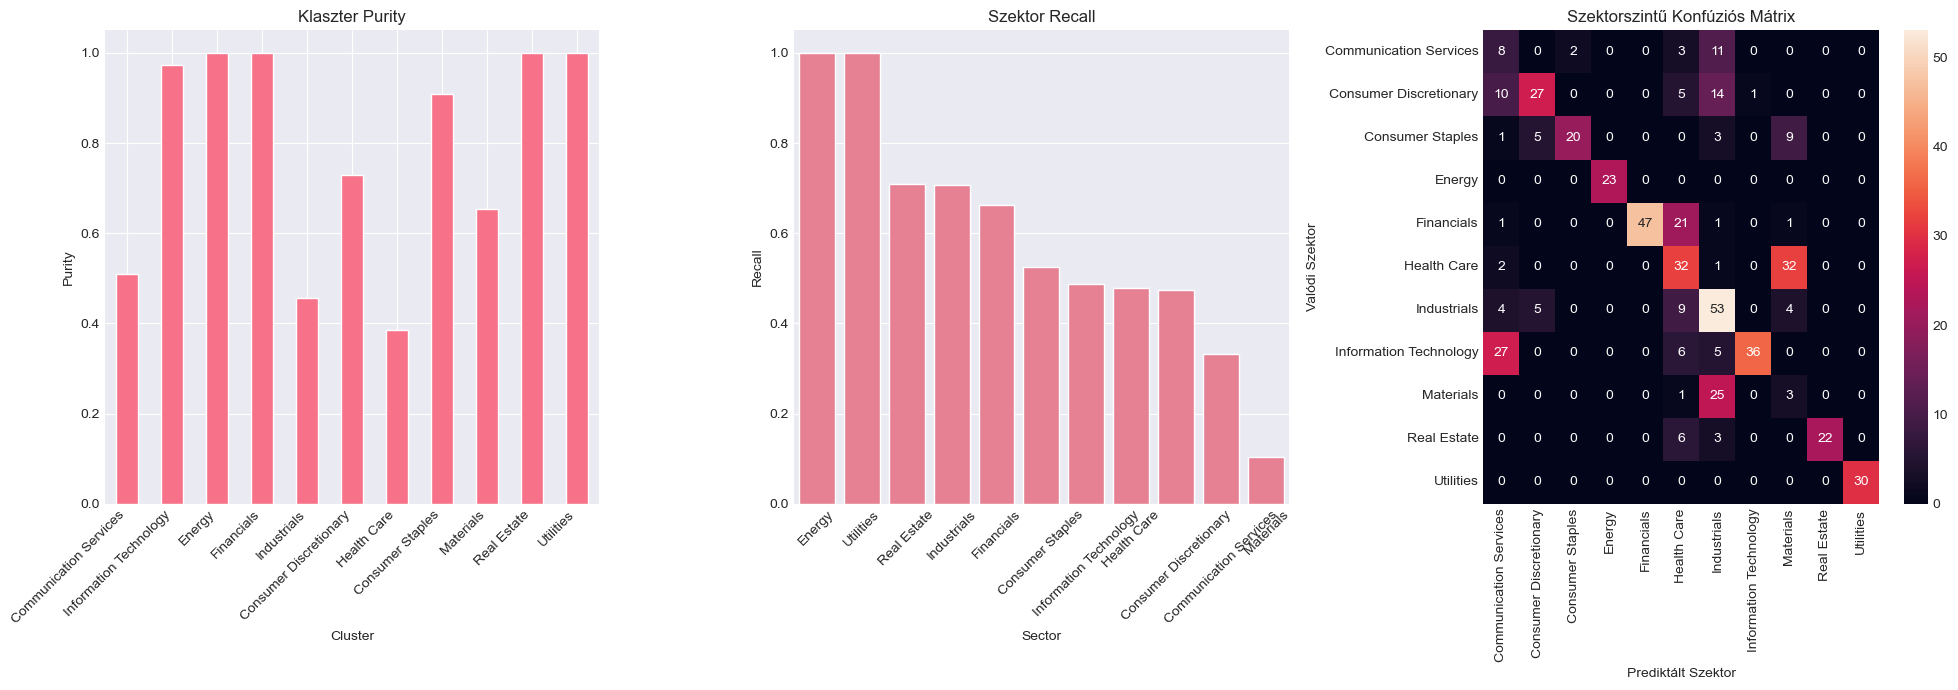

In [317]:
# 1. Szektor Adatok Egyesítése és Tisztítása
init_comparison_df = pd.merge(cluster_df, sector_map, on='Symbol', how='left')      # A klaszter-hozzárendelések és a valós szektorok összefésülése
comparison_df = init_comparison_df.dropna(subset=['Sector']).copy()                 # Csak a validálható adatok megtartása, a hiányzók eltávolítása (elvileg nincs inlyen)

# A prediktált klaszter-ID -k, valós szektor-nevek kinyerése
clusters_pred = comparison_df['Cluster'].values
sectors_true = comparison_df['Sector'].values

# Hungarian Algoritmus
ct = pd.crosstab(comparison_df["Sector"], comparison_df["Cluster"]) ##Gyakorisági táblázat: sorok a szektorok, az oszlopok a klaszterek

# Az algoritmus alapvetően költséget minimalizál, ezért a gyakoriságok negatívját vesszük (-ct.values),
# így a találatok számát fogjuk maximalizálni az optimális párosításnál
row_idx, col_idx = linear_sum_assignment(-ct.values)
best_matches = {ct.columns[c]: ct.index[r] for r, c in zip(row_idx, col_idx)} ##Dict létrehozása: klaszter-ID: szektor

#Metrikák
le = LabelEncoder()                                         #Szektornevek numerikus kódolása
y_true = le.fit_transform(comparison_df["Sector"])
y_pred_raw = comparison_df["Cluster"].values

# A klaszterek visszamappelése a Hungarian algoritmus által meghatározott szektornevekre
mapped_sector = comparison_df["Cluster"].map(best_matches)
y_pred = le.transform(mapped_sector)

purity = (comparison_df.groupby("Cluster")["Sector"].agg(lambda s: s.value_counts(normalize=True).max()).sort_index())  # Klaszterenkénti Purity

recall_df = pd.DataFrame({'Sector': le.classes_,'Recall': recall_score(y_true, y_pred, average=None)})                  # Szektor-szintű Recall
recall_df = recall_df.sort_values(by='Recall', ascending=False).set_index('Sector')

# Eredmények kiíratása
print(f"Accuracy after mapping:                  {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1:                                {f1_score(y_true, y_pred, average="macro"):.4f}")
print(f"Average cluster purity:                  {purity.mean():.4f}\n")

# A Rand Index és az NMI nem függ a Hungarian mappeléstől, a klaszterezés szerkezetét mérik
print(f"Adjusted Rand Index:                     {adjusted_rand_score(y_true, y_pred_raw):.4f}")
print(f"Normalized Mutual Information:           {normalized_mutual_info_score(y_true, y_pred_raw):.4f}\n")

# Grafikon
fig, ax = plt.subplots(1,3,figsize=(20, 7))

purity.plot(kind="bar", ax=ax[0])
ax[0].set_title("Klaszter Purity")
ax[0].set_ylabel("Purity")
ax[0].set_xticklabels([best_matches[i] for i in purity.index], rotation=45, ha="right")

sns.barplot(x=recall_df.index, y='Recall', data=recall_df, ax=ax[1])
ax[1].set_title('Szektor Recall')
ax[1].set_ylabel('Recall')
ax[1].set_xlabel('Sector')
ax[1].tick_params(axis='x', rotation=45)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
ax[2].set_title('Szektorszintű Konfúziós Mátrix')
ax[2].set_xlabel('Prediktált Szektor')
ax[2].set_ylabel('Valódi Szektor')
ax[2].tick_params(axis='x', rotation=90)
ax[2].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()



**Metrikák**:
 - Accuracy after mapping (0.58): A korreláció alapján besorolt részvények kb. fele került a hivatalos szektorához optimálisan hozzárendelt klaszterbe. Ez a mérték megerősíti, hogy a hipotézis részben állja meg a helyét, mert a véletlenszerű csopostosítás sokkal alacsonyabb eredményt ért volna el, de az egyezés csak mérsékelt
 - Macro F1 (0.61): Ez a Precision és a Recall harmonikus közepe. A „Macro” jelző azt jelenti, hogy minden szektort azonos súllyal kezel, függetlenül attól, hogy 76 (Industrials) vagy csak 24 (Comm. Services) cég van benne. Mivel az F1 magasabb, mint az Accuracy, ez azt jelenti, hogy az algoritmus a kisebb szektoroknál is viszonylag jól teljesített, nem csak a nagyok húzták fel az átlagot.
 - Average cluster purity (0.78): A 75% feletti érték azt jelenti, hogy a korreláció alapján létrehozott csoportok belsőleg nagyon homogének. Ha egy részvény bekerül egy klaszterbe, nagy valószínűséggel a többi részvény is ugyanahhoz a domináns szektorhoz tartozik.
 - Adjusted Rand Index (0.37): Azt méri, mennyire hasonlít a két felosztás (GICS vs. klaszterezés), miközben levonja a véletlen egyezés esélyét (1.0 = tökéletes, 0 = véletlen). Az 1.0-hoz képest alacsony, azt jelzi, hogy bár van összefüggés a piaci korreláció alapú struktúra alapvetően más, mint a GICS szektorfelosztás. Ez a hipotézis elutasításának legfőbb alapja.
 - Normalized Mutual Information (0.59): Azt méri, hogy ha ismerjük a klaszter-besorolást, mennyire tudjuk megmondani belőle a valódi szektort. 0,6-hoz közeli érték azt jelenti, hogy a klaszterek és a szektorok között jelentős információs átfedés van, azaz nem csak zajt klaszterezünk, hanem a szektorális struktúra "vázát" kaptuk vissza

**Grafikonok**

 - Klaszter Purity
    - A Purity kiemelkedő értéke közvetlen következménye a korábban mért magas szektoron belüli korrelációnak. Meg lehet figyelni, hogy pont az a 4 szektor értek el 1.0-ás Purityt, ami a 4 legmagasabb intra-szektor korrelációval rendelkezett. Mivel ezek a cégek gyakran együtt reagálnak eseményekre, a Ward-módszer (ami belső varianciát minimalizálja) nagyon könnyen meg találta azt a klasztert, amiben a többi cég van a szektorból.
 - Recall
    - Itt jön képbe az inter szektor korreláció. Míg a Purity-nél említett fontos tényező a klaszteren belüli variancia minimalizálása volt, itt belép a klaszterek közti távolság.
    - Látható, hogy azok a szektorok, melyen "távol" vannak a többitől, könnyen elkülöníthetőek, pláne, ha még sűrűek is, mint például az Energy, és Utilities szektorok.
    - Ami egy kicsit meg lepett, az a Communication Services, és a Consumer Discretionary rossz teljesítménye, mivel ezeknek a 3. és 4. legalacsonyabb az intra-szektor korrelációja. Viszont ha megviszgáljuk az intra-szektor grafikont, látható, hogy ezek közt nagyob a variancia, és így könnyebben szétszóródnak más klaszterek között.
    - Érdemesnek tartom megemlíteni, hogy fentebb az átlagokra hivatkoztam, de nyilván nem közömbös, hogy melyik érték mennyi az átlagban a klaszterezőnél. Lehet egy átlag alacsony, de van egy kiugró érték, és emiatt az ehhez tartozó szektorral gyakrabban kevethet az algoritmus.
 - Konfúziós mátrix
    - Tömegközéppont: Industrials inter-szektor korrelációja a legmagasabb, ennek pedig az a hatása, hogy ez a klaszter vált a piac "középpontjává", és rengeteg más szektorból került ide cég.
    - Sűrűségfüggő szóródás (Intra-korreláció hatása): Communication Services és a Consumer Staples alacsony találati arányt mutat, ez magyarázható azzal, hogy ezek a szektorok rendelkeznek a legalacsonyabb intra-szektor korrelációval.
    - Kényszerített párosítás: Erről a Hungarian algoritmus tehet, mivel mindenképp mind a 11 nevet "kiosztja", akkor is, ha a klaszterező kevesebb érdemi csoportot tudott csak azonosítani. A Materials és az Industrials között rendkívül magas az átfedés a magas inter-korreláció miatt.
    - Sikeres klaszterek: Az Energy és a Utilities tökéletes. A nagy sűrűség (Intra) és a többi csoporttól való nagy távolság (inter) ideális feltételeket teremt a Ward-módszer számára, így itt a legkisebb a tévesztés valószínűsége.





**A véletlenhez való viszonyítás**: 11 lehetséges szektor esetén a tisztán véletlenszerű besorolás várható pontossága, a szektorok méretével súlyozva ~11% lenne. Ehhez képest az 58%-os eredmény és a 0.37-es ARI azt bizonyítja, hogy a korreláció erős predikciós képességet hordoz, még ha nem is fedi le teljesen a mesterségesen létrehozott GICS kategóriákat.

**ARI vs. Purity**: Érdemes megfigyelni az ellentmondást a magas Purity és az alacsonyabb ARI között. A magas Purity azt jelenti, hogy a klaszterek 'belül' egységesek, nem keveredik sok minden egy csoportba. Az alacsonyabb ARI viszont azt mutatja, hogy bár a csoportok tiszták, nem feltétlenül a hivatalos szektorhatárok mentén jöttek létre. Ez a legfontosabb bizonyíték arra, hogy a piac máshogy csoportosít.

A klaszterezés sikeresen bebizonyította, hogy a defenzív szektorok (Közművek, Energia) és a nyersanyagok rendkívül egyedi statisztikai profillal rendelkeznek, így ezeket könnyű "felfedezni". Azonban a ciklikus szektorok (Consumer Discretionary, Industrials) esetében a korreláció alapú távolság nem elegendő. Ezek a cégek gyakran más szektorokhoz hasonlóan viselkednek (pl. az Amazon technológiai cégként, a Tesla növekedési papírként mozog), ami megzavarja a tiszta szektor-alapú felosztást.


**Összegzés**: Adjusted Rand Index alacsony értéke (0.3746) alapján a hipotézis, miszerint a korreláció szerinti csoportosítással pontosan szektorokra lehet bontani a részvényeket, elutasítható. Azonban az Average Cluster Purity (0.7833) magas értéke azt mutatja, hogy a klaszterezés nem véletlenszerű. A kapott csoportok viselkedésileg hasonlóak, ami azt jelenti, hogy a korreláció szektorokon átívelő viselkedési csoportokat (pl. növekedési részvények, kamatérzékeny részvények) azonosít, nem pedig kizárólag a hivatalos szektorokat.

**Mit kezdjünk ezzel a tudással?**

Az elemzés gyakorlati hasznát leginkább a portfóliókezelésben képzelem el. Ha egy befektető azt hiszi, hogy diverzifikált, mert van Industrials és Consumer Discretionary részvénye, a klaszterezés rávilágít, hogy ezek a korrelációs térben lehet egy klaszterbe esnek. Tehát valójában nem diverzifikált, mert a cégei ugyanúgy mozognak. A klaszterezés tehát nem elbukott a szektorok visszafejtésében, hanem megtalált "rejtett" összefüggéseket, megmutatva a valódi kockázati közösségeket.

# Modellépítés Szektor predikcióra korreláció alapján

A hipozéziseknél vizsgáltam azt, hogy nem felügyelt klaszterezés milyen teljesítménnyel tudja helyesen elválasztani a szektorokat a részvények korrelációja alapján. Adta magát, hogy ezt tegyem meg felügyelt tanulási algoritmusokkal is, tehát ebben a fejezetben, hasonlóan a hipotézishez, a korrelációs mátrix-szal tanított modelleket fogok vizsgálni. Először előkészítem az adatokat, csökkentem a dimenziót, majd megvizsgálom három különböző modell teljesíményét ezeken.

## Optimális komponensszám meghatározása


A részvények közötti korrelációs mátrix rendkívül magas dimenziószámú adat, amelyben minden egyes részvény egy újabb dimenziót jelent. Ezek gyakran tartalmaznak „zajt”, amelyek rontják a klaszterező algoritmusok hatékonyságát és pontosságát.


A dimenziócsökkentés céljából PCA-t alkalmazok. A folyamat során a célom nem egy előre meghatározott számú komponens kiválasztása volt, hanem egy olyan dinamikus megközelítés alkalmazása, amely az adatok belső varianciájára épít.


Ehhez az alábbi logikai lépéseket követtem:
 - Standardizálás: Mivel a PCA érzékeny az adatok skálájára, a korrelációs mátrixot először standardizáltam.
 - Teljes variancia feltérképezése: Első lépésben egy korlátozás nélküli PCA-t futtattam az összes lehetséges főkomponens kinyerésére.
 - Kumulatív magyarázó erő: Kiszámítottam a főkomponensek által magyarázott variancia kumulatív összegét. Ez megmutatja, hogy az első *k* számú komponens együttesen az eredeti információmennyiség mekkora részét őrzi meg.
 - Küszöbérték (Threshold) meghatározása: Meghatároztam egy 85%-os küszöböt, ami elég magas ahhoz, hogy a piaci struktúra lényeges elemeit megtartsa, de elég alacsony ahhoz, hogy jelentősen egyszerűsítse a modellt és kiszűrje a statisztikai zajt.


Az ötlet, hogy úgy így határozom meg a komponensek számát az enyém volt, viszont a megvalósításhoz egy LLM segíségét használtam fel.


In [318]:
X_std = StandardScaler().fit_transform(corr_matrix)     #Standardizálás
pca_full = PCA(n_components=None).fit(X_std)            # Összes komponenses PCA

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

threshold = 0.85
num_components = np.argmax(cumulative_variance >= threshold) + 1    #első olyan indexet adja vissza, ahol a feltétel igaz

print(f"A variancia {threshold*100:.0f}%-át magyarázó komponensek száma: {num_components}")

A variancia 85%-át magyarázó komponensek száma: 14


Az algoritmus szerint 14 főkomponens elegendő ahhoz, hogy a piaci mozgások 85%-át lefedjük, ami jelentős dimenziócsökkentést jelent az eredeti részvényszámhoz képest, miközben a releváns információk döntő többsége megmarad.

## Adatok előkészítése

A dimenziócsökkentés után a modell számára szükséges jellemzőmátrix és célváltozó előállítása.

Mivel a PCA során kinyert főkomponensek önmagukban csak absztrakt értékek, ezeket össze kell kapcsolni a szektorokkal.

A munkafolyamat lépései:

 - PCA: A korábban meghatározott optimális komponensszám alkalmazásával elvégeztem a tényleges vetítést. Az eredményeket egy új DataFrame-be rendeztem, ahol minden részvényt a legfontosabb főkomponensei reprezentálnak.
 - Adatok Összefűzése: A pca_df-et és a sector_map-et egyesítettem: csak azok a részvények kerülnek a modellbe, amelyekről rendelkezésre állt korrelációs adat az árfolyammozgásuk alapján, és van hozzájuk rendelt hivatalos szektorbesorolás is.
 - Célváltozó Kódolása: Mivel a gépi tanulási algoritmusok numerikus értékekkel dolgoznak, a szöveges szektorneveket a LabelEncoder segítségével egészekké alakítottam.
 - Rétegzett Felosztás (Stratified Split): Ez elengedhetetlen a tőzsdei adatoknál, mivel a szektorok mérete egyenlőtlen. A rétegzés biztosítja, hogy mindkét halmazban azonos maradjon a szektorok százalékos eloszlása, megelőzve ezzel, hogy a modell „vakon” maradjon a ritkább kategóriákra.

In [319]:
pca = PCA(n_components=num_components, random_state=random_state)   # PCA optimális komponensszámmal
X_pca = pca.fit_transform(corr_matrix)

# Eredmények DataFrame-be rendezése
pca_df = pd.DataFrame(
    X_pca,
    index=corr_matrix.index,
    columns=[f'PC{i+1}' for i in range(num_components)]
)

# Szektorinformációk csatolása
data = pca_df.join(sector_map, how='inner')

# Cél/magyarázó változók szétválasztása
X = data.drop(columns=['Sector']).values
y = data['Sector'].values

#Szektornevek numerikus kódolása
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.20,
    random_state=random_state,
    stratify=y_encoded ## A split megtartja az osztályok arányát, hogy ne legyen olyan, hogy pl nem jut Materials a train halmazba
)

## display(data)


## Modellek
A korábban kinyert 14 főkomponens önmagában még csak nyers bemeneti adat. Most ki fogok próbálni több különböző modellt, majd kiértékelem a kapott eredményeket.


### Random Forest

Ahhoz, hogy a lehető legpontosabb előrejelzést kapjuk, a GridSearchCV eljárást alkalmaztam. Ez a módszer szisztematikusan végigpróbálja a modell paramétereinek (fák száma, mélység, döntési kritérium) különböző kombinációit, és keresztvalidáció segítségével választja ki azt a konfigurációt, amely a legáltalánosabb és legstabilabb eredményt adja.

In [320]:
#Hiperparaméter-tér a rácskereséshez
param_grid_rf = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
rf = RandomForestClassifier(random_state=random_state)

# rácskeresés keresztvalidációval
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,            # 5-szörös keresztvalidáció
    scoring='accuracy'
)
#tanítás
grid_search_rf.fit(X_train, y_train)

# legjobb modell, és kiértékelése
print(f"Legjobb paraméterek: {grid_search_rf.best_params_}")
print(f"Legjobb keresztvalidációs pontosság: {grid_search_rf.best_score_:.3f}")

best_rf = grid_search_rf.best_estimator_
y_pred = best_rf.predict(X_test)

#Végső jelentés
accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_rf:.3f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Legjobb paraméterek: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Legjobb keresztvalidációs pontosság: 0.790
Accuracy: 0.817
                        precision    recall  f1-score   support

Communication Services       0.75      0.60      0.67         5
Consumer Discretionary       0.71      0.45      0.56        11
      Consumer Staples       1.00      0.75      0.86         8
                Energy       1.00      1.00      1.00         5
            Financials       0.72      0.93      0.81        14
           Health Care       1.00      1.00      1.00        13
           Industrials       0.71      0.80      0.75        15
Information Technology       0.68      0.87      0.76        15
             Materials       1.00      0.67      0.80         6
           Real Estate       1.00      0.83      0.91         6
             Utilities       1.00      1.00      1.00         6

              accuracy                           0.82       104

A modell 81.7%-os pontossága a teszt halmazon erős predikciós teljesítményre utal.

Főbb megállapítások:

 - Tökéletesen elkülönülő szektorok: Az Energy, Health Care és Utilities szektorok esetében a modell hibátlanul teljesített. Ezek a szektorok tehát olyan egyedi korrelációs mintázattal rendelkeznek, amely élesen elválik a piac többi részétől.
 - "Tech-zavar": Az Information Technology (Recall: 0.87) és Communication Services (Recall: 0.60) közötti korábbi nagy átfedés jelentősen csökkent. A modell megtanulta azokat a különbségeket a PCA-térben, amiket a korábbi klaszterező algoritmus még nem látott.
 - Nehézségek: A Consumer Discretionary szektor bizonyult a legnehezebb feladatnak (F1: 0.56). Ez arra utal, hogy a fogyasztási cikkek gyártói a piaci mozgásuk alapján gyakran hasonlítanak az ipari vagy technológiai papírokhoz.

### Gradient boosting

Miután a Random Foresttel sikerült egy alapszintet felállítani, a Gradient Boosting Classifier-t is megvizsgálom, hogy milyen teljesítményt ér el. Míg a Random Forest az átlagolásra épít, a Gradient Boosting egy optimalizációs folyamat, amely minden egyes új fa hozzáadásakor a gradiens mentén haladva csökkenti a modell veszteségfüggvényét.

A modellt ismét GridSearchCV segítségével optimalizáltam.

In [321]:
#Hiperparaméter-tér a rácskereséshez
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.15, 0.2],
    'max_depth': [1, 2, 3, 4]
}

gb = GradientBoostingClassifier(random_state=random_state)

# rácskeresés keresztvalidációval
grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    cv=5,            # 5-szörös keresztvalidáció
    scoring='accuracy',
    n_jobs=-1
)
#Tanítás
grid_search_gb.fit(X_train, y_train)

# legjobb modell, és kiértékelése
print(f"Legjobb paraméterek: {grid_search_gb.best_params_}")
print(f"Legjobb keresztvalidációs pontosság: {grid_search_gb.best_score_:.3f}")

best_gb = grid_search_gb.best_estimator_
y_pred = best_gb.predict(X_test)

#Végső jelentés
accuracy_gb = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_gb:.3f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Legjobb paraméterek: {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 100}
Legjobb keresztvalidációs pontosság: 0.742
Accuracy: 0.788
                        precision    recall  f1-score   support

Communication Services       1.00      0.60      0.75         5
Consumer Discretionary       0.78      0.64      0.70        11
      Consumer Staples       1.00      0.75      0.86         8
                Energy       1.00      0.80      0.89         5
            Financials       0.81      0.93      0.87        14
           Health Care       0.86      0.92      0.89        13
           Industrials       0.59      0.87      0.70        15
Information Technology       0.80      0.80      0.80        15
             Materials       0.50      0.33      0.40         6
           Real Estate       1.00      0.67      0.80         6
             Utilities       0.86      1.00      0.92         6

              accuracy                           0.79       104
             macro avg   

A modell 78.8%-os pontossága kisebb a Random Forest 81.7%-os eredményétől, viszont vannak különbségek:

 - Precizitás: Érdekes, hogy bizonyos szektorokban a GB pontosabb lett. A Communication Services, és Consumer Discretionary szektorokban is kifejezetten jobban teljesít.
 - Érzékenység a zajra: A Materials szektor eredményeinek drasztikus visszaesése arra utal, hogy a Gradient Boosting hajlamosabb volt a "zajra" fókuszálni ennél a kis mintaszámú csoportnál. Ez a modell érzékenyebb a hiperparaméterekre, és a jelek szerint a 14 főkomponens között talált olyan összefüggéseket, amik nem általánosíthatóak jól erre a szektorra.

 A Random Forest robusztusabbnak bizonyult ezen az adathalmazon. A GB max_depth: 2 értéke azt mutatja, hogy a modell nagyon egyszerű fákkal érte el a legjobb eredményt, ami azt jelzi, hogy a mélyebb, komplexebb összefüggések keresése már túltanuláshoz vezetne.

### Support vector classifier

Az SVM alkalmazása a 14 főkomponensre egyfajta "geometriai" megközelítést jelent. Az SVM különlegessége, hogy a döntési határát csak néhány kritikus adatpont határozza meg, ami elméletileg robusztussá teszi a modellt a távoli zajjal szemben.

In [322]:
#Hiperparaméter-tér a rácskereséshez
param_grid_svm = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [100, 125, 150, 175],
    'gamma': ['scale', 'auto', 0.01, 0.0125, 0.015]
}

svm = SVC(random_state=random_state)

# rácskeresés keresztvalidációval
grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    cv=5,            # 5-szörös keresztvalidáció
    scoring='accuracy',
    n_jobs=-1
)
#Tanítás
grid_search_svm.fit(X_train, y_train)

# legjobb modell, és kiértékelése
print(f"Legjobb paraméterek: {grid_search_svm.best_params_}")
print(f"Legjobb keresztvalidációs pontosság: {grid_search_svm.best_score_:.3f}")

best_svm = grid_search_svm.best_estimator_
y_pred = best_svm.predict(X_test)

#Végső jelentés
accuracy_svm = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_svm:.3f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Legjobb paraméterek: {'C': 125, 'gamma': 0.0125, 'kernel': 'rbf'}
Legjobb keresztvalidációs pontosság: 0.795
Accuracy: 0.808
                        precision    recall  f1-score   support

Communication Services       0.20      0.20      0.20         5
Consumer Discretionary       0.62      0.45      0.53        11
      Consumer Staples       0.88      0.88      0.88         8
                Energy       1.00      1.00      1.00         5
            Financials       0.88      1.00      0.93        14
           Health Care       1.00      1.00      1.00        13
           Industrials       0.71      0.80      0.75        15
Information Technology       0.71      0.80      0.75        15
             Materials       1.00      0.67      0.80         6
           Real Estate       1.00      0.83      0.91         6
             Utilities       1.00      1.00      1.00         6

              accuracy                           0.81       104
             macro avg       0.82      0.

Az SVM modell eredményei újabb eltéréseket mutatnak a kiértékelésnél. A modell 81%-os pontossága szinte azonos a Random Forest szintjével, de a szektoronkénti bontásban látszanak az SVM specifikus jellemzői.

 - Stabilitás: Az Energy, Health Care és Utilities szektorok itt is tökéletes, 1.00-ás F1-score-t értek el. Ez egyértelmű bizonyítéka annak, hogy ezek a szektorok geometriailag is teljesen elkülönülnek a korrelációs térben.
 - Nehézségek: A Communication Services szektornál az SVM gyengébben teljesített (F1: 0.20), mint a fa-alapú modellek. Ez arra utal, hogy ez a szektor nem alkot egyetlen összefüggő "tömböt" a térben, hanem több apró szigetre szakad, amiket ez a modell nehezebben tud elhatárolni a zajtól.

## Konklúzió

Átfogó értékelés és modell-összehasonlítás:

A kutatás egyik fő kérdése az volt, hogy a részvények árfolyam-korrelációja mennyire hordozza magában a szektor-besorolást. A válasz egyértelműen pozitív: míg a felügyelet nélküli klaszterezés (Accuracy: 0.58) csak a piaci struktúra alapjait találta meg, a felügyelt tanulási modellek (80% feletti pontosság) bebizonyították, hogy az adatokban rejlő összefüggések szinte teljes mértékben alkalmasak a szektor-azonosításra.

A modellek teljesítményének kontrasztja
A különbségi mátrixok (rf-svm, rf-gb, gb-svm) alapján, melyeket excel-ben vizsgáltam és az alábbi konklúziókat vontam le:

Random Forest vs. Többiek: A Random Forest bizonyult a legstabilabbnak a legtöbb szektorban. Az SVM-hez képest előnye van a Communication Services (F1-score különbség: +0.47) és a Consumer Discretionary (+0.03) szektorokban. Ez azt jelzi, hogy a fa-alapú hierarchikus döntések jobban kezelik a térben szétszórt, "szigetszerű" szektorokat.

Gradient Boosting Sikerei: Bár a GB összesített pontossága valamivel alacsonyabb (79%), az SVM-mel szemben kimagaslóan jól teljesített a Communication Services szektorban (+0.55 F1-score különbség). Ugyanakkor az RF-hez képest (rf-gb) alulmaradt a Materials (-0.40) és a Consumer Discretionary (-0.14) terén.

SVM Karakterisztikája: Az SVM geometriai módszere rendkívül precíz a jól elkülönülő szektoroknál, de a különbségi táblázatok lilával jelzett mezői mutatják, hogy a bonyolultabb eloszlású csoportokban (mint a Communication Services vagy a Consumer Discretionary) gyakran elmarad a fa-alapú modellek rugalmasságától.



A vizsgálat igazolta, hogy a részvénypiacon a korreláció alapú dimenziócsökkentés egy rendkívül hatékony jellemző-kinyerési módszer.

A Random Forest a legjobb választás az általános piaci osztályozáshoz (Accuracy: 0.817), mivel ez tudta a legjobban kezelni a zajosabb, átfedő szektorokat.

A Support Vector Machine (SVM) kiváló alternatíva a stabil, nagyvállalati szektorok (Financials, Energy) azonosítására.

A Gradient Boosting bizonyos specifikus szektorokban (pl. Communication) mutatott extra precizitást, de érzékenyebb a kisméretű szektorok (Materials) zajára.

# Összegzés

A házi feladat végére sok új módszerrel megismerkedtem. Alapvető ötletek sajátjaim voltak, viszont alkalmaztam LLM által javasolt javításokat, és ismeretlenebb területeken felhasználtam, hogy jobban el tudjak mélyülni, és megismerni az adott témát, például a modellek hiperparaméter optimalizációja, és a grafikonok megjelenítésének különböző módszerei, beállításai.

A jövőben kiváncsi lennék, az elemzéseimet hogy befolyásolná a piaci kapitalizáció alapú súlyozás. Mire a végére jutottam, több olyan gondolatom is volt amik nem kerültek bele a kész feladatba, ezek közül például az inflációs rezsim prediktálása különböző modellekkel a hozamok alapján, a cégek IPO dátumainak és a piaci kapitalizáció közti kapcsolat vizsgálata és a részvények közti korreláció változása bizonyos inflációs rezsimekben. Emellett a későbbiekben szivesen belemélyednék konkrét cégek részletesebb vizsgálatába, amihez nyilván nem csak az árfolyamot, és inflációs kötnyezetet használnám fel.